# 🎓 Real/Fake Detection - TEST Notebook

Bu notebook, önceden eğitilmiş `model_epoch_18.pth` modeli ile doğrulama seti üzerinde test yapar.

**Akış:**
1. Setup
2. Veri Yükleme
3. Best Model Yükleme
4. Inference & Değerlendirme
5. Görselleştirmeler


## 1️⃣ Setup


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
from utils import *
import json
from datetime import datetime

# ============================================
# 🎛️ AYARLAR - Buradan kolayca değiştirin!
# ============================================
NOTEBOOK_NAME = "real_fake_TEST"
DATA_DIR = r"C:\AI_DATA\SEMI_TRUTHS_extracted"
CLASS_NAMES = ["real", "fake"]

BATCH_SIZE = 32
VAL_SPLIT = 0.2

# ============================================
# 🔑 EĞİTİMDEKİ SEED DEĞERLERİ (DEĞİŞTİRMEYİN!)
# ============================================
# Bu değerler eğitim sırasında kullanıldı
# Aynı train/val split'i elde etmek için gerekli
RANDOM_SEED = 42                 # Stratified sampling için (random.seed)
SPLIT_SEED = 42                  # Train/Val split için (torch.Generator)

# ============================================
# 📊 TEST VERİSİ KONTROLÜ
# ============================================
# None = tüm veriyi kullan, sayı = o kadar örnek kullan
MAX_TEST_SAMPLES = None          # Toplam maksimum test örneği (None = sınırsız)
MAX_SAMPLES_PER_CLASS = None     # Sınıf başına maksimum örnek (None = sınırsız)

# 💡 Hızlı test için önerilen değerler:
# MAX_TEST_SAMPLES = 1000        # Hızlı test: 1000 örnek
# MAX_SAMPLES_PER_CLASS = 500    # Sınıf başına 500 örnek

# Setup
device = setup_device()

# ============================================
# 🔥 GPU KULLANIMI KESİN DOĞRULAMA
# ============================================
print("\n" + "="*70)
print("🔥 GPU KULLANIMI DOĞRULAMA")
print("="*70)

# GPU kontrolü
if torch.cuda.is_available():
    print(f"✅ CUDA mevcut: {torch.cuda.is_available()}")
    print(f"✅ GPU adı: {torch.cuda.get_device_name(0)}")
    print(f"✅ CUDA versiyonu: {torch.version.cuda}")
    print(f"✅ GPU sayısı: {torch.cuda.device_count()}")
    
    # GPU bilgileri
    props = torch.cuda.get_device_properties(0)
    print(f"✅ VRAM: {props.total_memory / 1024**3:.2f} GB")
    
    # GPU'yu aktif et
    torch.cuda.set_device(0)
    device = torch.device("cuda:0")
    
    # GPU cache'i temizle
    torch.cuda.empty_cache()
    
    # Test: GPU'da tensor oluştur
    test_tensor = torch.randn(10, 10).to(device)
    if test_tensor.device.type == "cuda":
        print(f"✅ GPU test başarılı: Tensor GPU'da ({test_tensor.device})")
    else:
        print(f"❌ HATA: Tensor GPU'da değil! ({test_tensor.device})")
    del test_tensor
    torch.cuda.empty_cache()
    
    print("="*70)
else:
    print("❌ CUDA mevcut değil! CPU kullanılacak.")
    device = torch.device("cpu")
    print("="*70)
# ============================================
# 📅 TARİH BAZLI KLASÖRLEME - Her test ayrı klasörde
# ============================================
TEST_TIMESTAMP = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
TEST_RUN_ID = f"test_{TEST_TIMESTAMP}"

# Tarih bazlı test klasörü oluştur
base_folders = create_training_folder(NOTEBOOK_NAME)
test_root = os.path.join(base_folders["base"], TEST_RUN_ID)

folders = {
    "root": test_root,
    "data": os.path.join(test_root, "veriler"),
    "plots": os.path.join(test_root, "görseller"),
    "models": base_folders.get("models", os.path.join(test_root, "modeller")),
    "logs": os.path.join(test_root, "loglar")
}

# Alt klasörler
folders["data_analysis"] = os.path.join(folders["data"], "analysis")
folders["plots_analysis"] = os.path.join(folders["plots"], "analysis")
folders["plots_detailed"] = os.path.join(folders["plots"], "detailed_analysis")

# Klasörleri oluştur
for folder_path in folders.values():
    os.makedirs(folder_path, exist_ok=True)
    
# ============================================
# 📋 BİLGİ YAZDIRMA
# ============================================
print("="*70)
print(f"📅 TEST ÇALIŞTIRMA: {TEST_RUN_ID}")
print("="*70)
print(f"Notebook: {NOTEBOOK_NAME}")
print(f"Veri: {DATA_DIR}")
print(f"Sınıflar: {CLASS_NAMES}")
print(f"\n🔑 Seed Değerleri (eğitimdeki ile aynı):")
print(f"   RANDOM_SEED: {RANDOM_SEED}")
print(f"   SPLIT_SEED: {SPLIT_SEED}")
print(f"\n🎛️ Test Veri Limitleri:")
print(f"   MAX_TEST_SAMPLES: {MAX_TEST_SAMPLES if MAX_TEST_SAMPLES else 'Sınırsız'}")
print(f"   MAX_SAMPLES_PER_CLASS: {MAX_SAMPLES_PER_CLASS if MAX_SAMPLES_PER_CLASS else 'Sınırsız'}")
print(f"\n📁 Test Klasörü: {test_root}")
print(f"🖥️  Device: {device}")


✅ GPU kullanılıyor: NVIDIA GeForce RTX 4060 Laptop GPU

🔥 GPU KULLANIMI DOĞRULAMA
✅ CUDA mevcut: True
✅ GPU adı: NVIDIA GeForce RTX 4060 Laptop GPU
✅ CUDA versiyonu: 12.1
✅ GPU sayısı: 1
✅ VRAM: 8.00 GB
✅ GPU test başarılı: Tensor GPU'da (cuda:0)
✅ Klasör yapısı oluşturuldu: eğitim_sonuçları\real_fake_TEST
📅 TEST ÇALIŞTIRMA: test_2025-12-13_02-25-24
Notebook: real_fake_TEST
Veri: C:\AI_DATA\SEMI_TRUTHS_extracted
Sınıflar: ['real', 'fake']

🔑 Seed Değerleri (eğitimdeki ile aynı):
   RANDOM_SEED: 42
   SPLIT_SEED: 42

🎛️ Test Veri Limitleri:
   MAX_TEST_SAMPLES: Sınırsız
   MAX_SAMPLES_PER_CLASS: Sınırsız

📁 Test Klasörü: eğitim_sonuçları\real_fake_TEST\test_2025-12-13_02-25-24
🖥️  Device: cuda:0


## 2️⃣ Veri Yükleme


In [4]:
from torch.utils.data import DataLoader, Dataset, random_split, Subset
from torchvision import transforms
from PIL import Image
from collections import Counter
import random

class RealFakeDataset(Dataset):
    """Real/Fake resim dataseti
    
    Klasör yapısı:
    DATA_DIR/
    ├── original/images/     (REAL resimler)
    └── inpainting/          (FAKE resimler)
    """
    
    def __init__(self, data_dir, transform=None):
        self.data = []
        self.transform = transform
        
        # Real resimler (label=0)
        real_dir = os.path.join(data_dir, 'original', 'images')
        if os.path.exists(real_dir):
            for root, dirs, files in os.walk(real_dir):
                for file in files:
                    if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                        self.data.append((os.path.join(root, file), 0))
        
        # Fake resimler (label=1)
        fake_dir = os.path.join(data_dir, 'inpainting')
        if os.path.exists(fake_dir):
            for root, dirs, files in os.walk(fake_dir):
                for file in files:
                    if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                        self.data.append((os.path.join(root, file), 1))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image_path, label = self.data[idx]
        try:
            image = Image.open(image_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
        except Exception as e:
            print(f"Hata: {image_path}")
            return None, None
        return image, label

# Val Transform (test için augmentation yok)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Veri Yükleme
print("\n📋 VERİ YÜKLEME")
print("="*70)

full_dataset = RealFakeDataset(DATA_DIR, transform=val_transform)
print(f"✅ Tam Dataset: {len(full_dataset)} görsel")

labels = [label for _, label in full_dataset.data]
label_counts = Counter(labels)
print(f"   Real: {label_counts[0]:,}")
print(f"   Fake: {label_counts[1]:,}")

# ============================================
# ⚠️ ÖNEMLİ: EĞİTİMDEKİ AYNI SPLIT'İ KULLAN
# ============================================
# Eğitimde seed=42 kullanıldı, aynı seed ile split yaparak
# SADECE validation setini kullanıyoruz (train setini test'te kullanmıyoruz)
# NOT: Real ve Fake verilerini eşitlemiyoruz - tüm veriyi kullanıyoruz

# Tüm dataset'i kullan (eşitleme yok)
all_indices = list(range(len(full_dataset)))

# 🎛️ KULLANICI LİMİTLERİNİ UYGULA (opsiyonel)
if MAX_TEST_SAMPLES is not None:
    random.seed(RANDOM_SEED)
    all_indices = random.sample(all_indices, min(MAX_TEST_SAMPLES, len(all_indices)))
    print(f"\n⚙️ Toplam limit uygulandı: {MAX_TEST_SAMPLES} örnek")

# Train/Val split
train_size = int(len(all_indices) * (1 - VAL_SPLIT))
val_size = len(all_indices) - train_size

# 🔑 PyTorch random_split için AYNI SEED kullan (SPLIT_SEED)
split_generator = torch.Generator().manual_seed(SPLIT_SEED)
train_indices, val_indices = random_split(all_indices, [train_size, val_size], generator=split_generator)

# Val indekslerini al
val_full_indices = [all_indices[i] for i in val_indices.indices]
train_full_indices = [all_indices[i] for i in train_indices.indices]

print(f"\n✅ Train/Val Split (seed=42 ile eğitimdeki aynı):")
print(f"   Train: {len(train_full_indices):,} örnek (TEST'TE KULLANILMIYOR)")
print(f"   Val: {len(val_full_indices):,} örnek (TEST EDİLECEK)")
print(f"\n🔒 Eğitimde kullanılan train verisi test'e DAHİL DEĞİL!")


📋 VERİ YÜKLEME
✅ Tam Dataset: 160068 görsel
   Real: 22,963
   Fake: 137,105

✅ Train/Val Split (seed=42 ile eğitimdeki aynı):
   Train: 128,054 örnek (TEST'TE KULLANILMIYOR)
   Val: 32,014 örnek (TEST EDİLECEK)

🔒 Eğitimde kullanılan train verisi test'e DAHİL DEĞİL!


## 3️⃣ Model Tanımı & Best Model Yükleme


In [ ]:
from torchvision import models

class RealFakeModel(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.backbone.fc = nn.Linear(2048, num_classes)
    
    def forward(self, x):
        return self.backbone(x)

# Best model yükle
BEST_MODEL_PATH = r"eğitim_sonuçları\real_fake_detection\models\v4\model_epoch_18.pth"

if not os.path.exists(BEST_MODEL_PATH):
    raise FileNotFoundError(f"Model bulunamadı: {BEST_MODEL_PATH}")

model = RealFakeModel(num_classes=len(CLASS_NAMES)).to(device)
state_dict = torch.load(BEST_MODEL_PATH, map_location=device, weights_only=True)
model.load_state_dict(state_dict)
model.eval()

# ============================================
# 🔥 MODEL GPU'DA DOĞRULAMA
# ============================================
print("\n" + "="*70)
print("🔥 MODEL GPU KULLANIMI DOĞRULAMA")
print("="*70)

# Model parametrelerinin device'ını kontrol et
first_param = next(model.parameters())
model_device = first_param.device
print(f"✅ Model device: {model_device}")

if model_device.type == "cuda":
    print(f"✅ Model GPU'da: {torch.cuda.get_device_name(model_device.index)}")
    # GPU'da test inference
    test_input = torch.randn(1, 3, 224, 224).to(device)
    with torch.no_grad():
        test_output = model(test_input)
    if test_output.device.type == "cuda":
        print(f"✅ Test inference GPU'da başarılı!")
    else:
        print(f"❌ HATA: Test inference GPU'da değil!")
    del test_input, test_output
    torch.cuda.empty_cache()
else:
    print(f"⚠️  Model CPU'da! GPU kullanılamıyor.")
print("="*70)

model_size_mb = os.path.getsize(BEST_MODEL_PATH) / (1024 ** 2)
print(f"✅ Model yüklendi: {BEST_MODEL_PATH}")
print(f"   Boyut: {model_size_mb:.2f} MB")

# ============================================
# 📋 TEST METADATA KAYDI
# ============================================
test_metadata = {
    "test_run_id": TEST_RUN_ID,
    "test_timestamp": TEST_TIMESTAMP,
    "notebook_name": NOTEBOOK_NAME,
    "model_path": BEST_MODEL_PATH,
    "model_size_mb": round(model_size_mb, 2),
    "data_dir": DATA_DIR,
    "class_names": CLASS_NAMES,
    "batch_size": BATCH_SIZE,
    "val_split": VAL_SPLIT,
    "random_seed": RANDOM_SEED,
    "split_seed": SPLIT_SEED,
    "max_test_samples": MAX_TEST_SAMPLES,
    "max_samples_per_class": MAX_SAMPLES_PER_CLASS,
    "device": str(device),
    "test_folder": test_root
}

# Metadata'yı JSON olarak kaydet
metadata_path = os.path.join(folders["root"], "test_metadata.json")
with open(metadata_path, "w", encoding="utf-8") as f:
    json.dump(test_metadata, f, indent=2, ensure_ascii=False)

print(f"\n✅ Test metadata kaydedildi: {metadata_path}")



🔥 MODEL GPU KULLANIMI DOĞRULAMA
✅ Model device: cuda:0
✅ Model GPU'da: NVIDIA GeForce RTX 4060 Laptop GPU
✅ Test inference GPU'da başarılı!
✅ Model yüklendi: eğitim_sonuçları\real_fake_detection\models\v4\model_epoch_18.pth
   Boyut: 90.00 MB

✅ Test metadata kaydedildi: eğitim_sonuçları\real_fake_TEST\test_2025-12-13_02-25-24\test_metadata.json


## 4️⃣ Evaluation Dataset & DataLoader


In [ ]:
class EvalDatasetWithPaths(Dataset):
    """Val örneklerini path bilgisiyle birlikte döndür."""

    def __init__(self, base_dataset, indices, transform=None):
        self.base_dataset = base_dataset
        self.indices = indices
        self.transform = transform
        self.skipped = []  # Bozuk dosyaları takip et

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        actual_idx = self.indices[idx]
        image_path, label = self.base_dataset.data[actual_idx]
        
        try:
            image = Image.open(image_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
            return image, label, image_path
        except Exception as e:
            # Bozuk görsel - placeholder döndür
            self.skipped.append(image_path)
            # 224x224 siyah görsel oluştur
            dummy_image = Image.new("RGB", (224, 224), (0, 0, 0))
            if self.transform:
                dummy_image = self.transform(dummy_image)
            return dummy_image, label, f"BROKEN:{image_path}"


eval_dataset = EvalDatasetWithPaths(full_dataset, val_full_indices, transform=val_transform)

# ============================================
# 🔥 DATALOADER GPU OPTİMİZASYONU
# ============================================
# GPU varsa num_workers ve pin_memory optimize et
if torch.cuda.is_available():
    # GPU için optimize edilmiş ayarlar
    num_workers = min(0, os.cpu_count() or 1)  # CPU core sayısına göre
    pin_memory = True  # GPU'ya hızlı transfer için
    print(f"✅ DataLoader GPU optimizasyonu:")
    print(f"   num_workers: {num_workers}")
    print(f"   pin_memory: {pin_memory}")
else:
    num_workers = 0
    pin_memory = False
    print(f"⚠️  DataLoader CPU modu:")
    print(f"   num_workers: {num_workers}")
    print(f"   pin_memory: {pin_memory}")

eval_loader = DataLoader(
    eval_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory,
    persistent_workers=True if num_workers > 0 else False
)

print(f"✅ Eval örnekleri: {len(eval_dataset):,}")
print(f"   Batch sayısı: {len(eval_loader)}")


✅ DataLoader GPU optimizasyonu:
   num_workers: 0
   pin_memory: True
✅ Eval örnekleri: 32,014
   Batch sayısı: 1001


## 5️⃣ Mask Magnitude Lookup Oluştur


In [8]:
import glob

CSV_META_ROOT = r"C:\AI_DATA\SEMI_TRUTHS\inpainting"

# Okunacak sütunlar - hem kategorik hem sayısal metrikler
META_COLUMNS = [
    "perturbed_img_id", 
    "sem_magnitude",    # Kategorik: small, medium, large
    "area_ratio",       # Sayısal: mask alan oranı (0-1)
    "ssim",             # Yapısal benzerlik (0-1)
    "mse",              # Mean squared error
    "lpips_score",      # Perceptual benzerlik
    "dreamsim",         # DreamSim skoru
]


def build_magnitude_lookup(csv_root):
    """CSV dosyalarından hem kategorik hem sayısal magnitude bilgilerini çıkar."""
    csv_files = glob.glob(os.path.join(csv_root, "**", "*_meta.csv"), recursive=True)
    print(f"Meta CSV dosyaları: {len(csv_files)}")
    
    # Kategorik lookup (eski - geriye uyumluluk)
    lookup = {}
    # Genişletilmiş lookup - tüm metrikler
    lookup_extended = {}

    for csv_file in csv_files:
        try:
            # Mevcut sütunları kontrol et
            df_sample = pd.read_csv(csv_file, nrows=1)
            available_cols = [col for col in META_COLUMNS if col in df_sample.columns]
            df = pd.read_csv(csv_file, usecols=available_cols)
        except Exception as exc:
            print(f"⚠️ {os.path.basename(csv_file)} okunamadı: {exc}")
            continue

        df = df.dropna(subset=["perturbed_img_id"])
        
        for row in df.itertuples(index=False):
            key = str(row.perturbed_img_id).strip().lower()
            if not key:
                continue
            
            # Kategorik magnitude (eski format)
            if hasattr(row, 'sem_magnitude') and pd.notna(row.sem_magnitude):
                lookup[key] = str(row.sem_magnitude).strip().lower()
            
            # Genişletilmiş bilgiler
            extended_info = {
                "sem_magnitude": str(row.sem_magnitude).strip().lower() if hasattr(row, 'sem_magnitude') and pd.notna(row.sem_magnitude) else "unknown",
                "area_ratio": float(row.area_ratio) if hasattr(row, 'area_ratio') and pd.notna(row.area_ratio) else None,
                "ssim": float(row.ssim) if hasattr(row, 'ssim') and pd.notna(row.ssim) else None,
                "mse": float(row.mse) if hasattr(row, 'mse') and pd.notna(row.mse) else None,
                "lpips_score": float(row.lpips_score) if hasattr(row, 'lpips_score') and pd.notna(row.lpips_score) else None,
                "dreamsim": float(row.dreamsim) if hasattr(row, 'dreamsim') and pd.notna(row.dreamsim) else None,
            }
            lookup_extended[key] = extended_info

    return lookup, lookup_extended


def get_magnitude_from_path(image_path, lookup):
    """Kategorik magnitude değerini döndür (geriye uyumluluk)."""
    name_key = os.path.splitext(os.path.basename(image_path))[0].strip().lower()
    return lookup.get(name_key, "unknown")


def get_extended_info_from_path(image_path, lookup_extended):
    """Tüm magnitude metriklerini döndür."""
    name_key = os.path.splitext(os.path.basename(image_path))[0].strip().lower()
    default_info = {
        "sem_magnitude": "unknown",
        "area_ratio": None,
        "ssim": None,
        "mse": None,
        "lpips_score": None,
        "dreamsim": None,
    }
    return lookup_extended.get(name_key, default_info)


magnitude_lookup, magnitude_lookup_extended = build_magnitude_lookup(CSV_META_ROOT)
print(f"📦 Mask magnitude kayıtları (kategorik): {len(magnitude_lookup):,}")
print(f"📦 Genişletilmiş metrik kayıtları: {len(magnitude_lookup_extended):,}")

# Özet istatistik
if magnitude_lookup_extended:
    sample_keys = list(magnitude_lookup_extended.keys())[:5]
    print(f"\n📋 Örnek kayıtlar:")
    for k in sample_keys:
        info = magnitude_lookup_extended[k]
        print(f"   {k[:50]}... → mag={info['sem_magnitude']}, area={info['area_ratio']}")


Meta CSV dosyaları: 6
📦 Mask magnitude kayıtları (kategorik): 192,436
📦 Genişletilmiş metrik kayıtları: 192,436

📋 Örnek kayıtlar:
   instance_000_ade_frame_00000004_ade20k_stablediffu... → mag=small, area=0.1498832702636718
   instance_003_ade_frame_00000004_ade20k_stablediffu... → mag=small, area=0.1233444213867187
   instance_004_ade_frame_00000004_ade20k_stablediffu... → mag=small, area=0.1207771301269531
   instance_005_ade_frame_00000004_ade20k_stablediffu... → mag=large, area=0.0851593017578125
   instance_006_ade_frame_00000004_ade20k_stablediffu... → mag=large, area=0.0409736633300781


## 6️⃣ Inference


In [ ]:
from tqdm.auto import tqdm  # notebook uyumlu, ipywidgets olmasa da çalışır

results = []
broken_count = 0

model.eval()

# ============================================
# 🔥 INFERENCE GPU KULLANIMI DOĞRULAMA
# ============================================
print("\n" + "="*70)
print("🔥 INFERENCE BAŞLIYOR - GPU KULLANIMI")
print("="*70)
print(f"✅ Model device: {next(model.parameters()).device}")
print(f"✅ Inference device: {device}")
if torch.cuda.is_available():
    print(f"✅ GPU: {torch.cuda.get_device_name(0)}")
    torch.cuda.reset_peak_memory_stats()
print("="*70 + "\n")

with torch.no_grad():
    for batch_idx, (images, labels, paths) in enumerate(tqdm(eval_loader, desc="Inference", leave=True)):
        # GPU'ya taşı ve doğrula
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        # İlk batch'te GPU kullanımını doğrula
        if batch_idx == 0:
            if images.device.type != "cuda":
                print(f"❌ HATA: Images GPU'da değil! Device: {images.device}")
            else:
                print(f"✅ İlk batch GPU'da: {images.device}")
        
        # Inference

        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        confs, preds = torch.max(probs, dim=1)

        for img_path, label_idx, pred_idx, conf_val, prob_vec in zip(paths, labels, preds, confs, probs):
            # Bozuk görselleri atla
            if img_path.startswith("BROKEN:"):
                broken_count += 1
                continue
                
            label_int = int(label_idx.item())
            pred_int = int(pred_idx.item())
            
            # Genişletilmiş metrik bilgilerini al
            # Inference kısmında (results.append içinde):
            # Genişletilmiş metrik bilgilerini al
            ext_info = get_extended_info_from_path(img_path, magnitude_lookup_extended)

            # Area ratio'ya göre mask magnitude (fiziksel boyut) kategorisi
            area_ratio_val = ext_info["area_ratio"]
            if area_ratio_val is not None:
                if area_ratio_val < 0.1:
                    mask_magnitude_physical = "small"
                elif area_ratio_val < 0.3:
                    mask_magnitude_physical = "medium"
                else:
                    mask_magnitude_physical = "large"
            else:
                mask_magnitude_physical = "unknown"

            results.append({
                "image_path": img_path,
                "true_label_idx": label_int,
                "pred_label_idx": pred_int,
                "true_label": CLASS_NAMES[label_int],
                "pred_label": CLASS_NAMES[pred_int],
                "confidence": float(conf_val.item()),
                "prob_real": float(prob_vec[0].item()),
                "prob_fake": float(prob_vec[1].item()),
                # Semantic magnitude (anlam bozukluğu boyutu)
                "semantic_magnitude": ext_info["sem_magnitude"],
                # Mask magnitude (fiziksel boyut - area_ratio'ya göre)
                "mask_magnitude": mask_magnitude_physical,
                # Sayısal metrikler
                "area_ratio": ext_info["area_ratio"],
                "ssim": ext_info["ssim"],
                "mse": ext_info["mse"],
                "lpips_score": ext_info["lpips_score"],
                "dreamsim": ext_info["dreamsim"],
            })

results_df = pd.DataFrame(results)

# ============================================
# 🔥 INFERENCE SONRASI GPU İSTATİSTİKLERİ
# ============================================
if torch.cuda.is_available():
    print("\n" + "="*70)
    print("🔥 GPU KULLANIM İSTATİSTİKLERİ")
    print("="*70)
    print(f"✅ Peak GPU Memory Allocated: {torch.cuda.max_memory_allocated() / 1024**3:.2f} GB")
    print(f"✅ Peak GPU Memory Reserved: {torch.cuda.max_memory_reserved() / 1024**3:.2f} GB")
    print(f"✅ Current GPU Memory Allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"✅ Current GPU Memory Reserved: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")
    print("="*70)

print(f"\n✅ Toplam inference: {len(results_df):,}")
if broken_count > 0:
    print(f"⚠️ Bozuk/atlanan görsel: {broken_count:,}")

# Sayısal metriklerin özeti (sadece fake örnekler için)
fake_samples = results_df[results_df["true_label"] == "fake"]
if not fake_samples.empty:
    print(f"\n📊 Fake örneklerin sayısal metrikleri:")
    numeric_cols = ["area_ratio", "ssim", "mse", "lpips_score", "dreamsim"]
    for col in numeric_cols:
        valid_count = fake_samples[col].notna().sum()
        if valid_count > 0:
            print(f"   {col}: {valid_count:,} kayıt (mean={fake_samples[col].mean():.4f})")


Inference:   0%|          | 0/1001 [00:00<?, ?it/s]


✅ Toplam inference: 32,014

📊 Fake örneklerin sayısal metrikleri:
   area_ratio: 25,848 kayıt (mean=0.1095)
   ssim: 25,848 kayıt (mean=0.8125)
   mse: 25,848 kayıt (mean=0.0145)
   lpips_score: 25,848 kayıt (mean=0.1056)
   dreamsim: 25,848 kayıt (mean=0.1420)


## 7️⃣ Metrikler & Confusion Matrix



📊 TEST SONUÇLARI
Accuracy        : 99.12%
Real precision  : 95.75%
Fake precision  : 99.71%
Real recall     : 98.26%
Fake recall     : 99.27%
✅ Grafik kaydedildi: eğitim_sonuçları\real_fake_TEST\test_2025-12-12_23-54-29\görseller\analysis\confusion_matrix.png


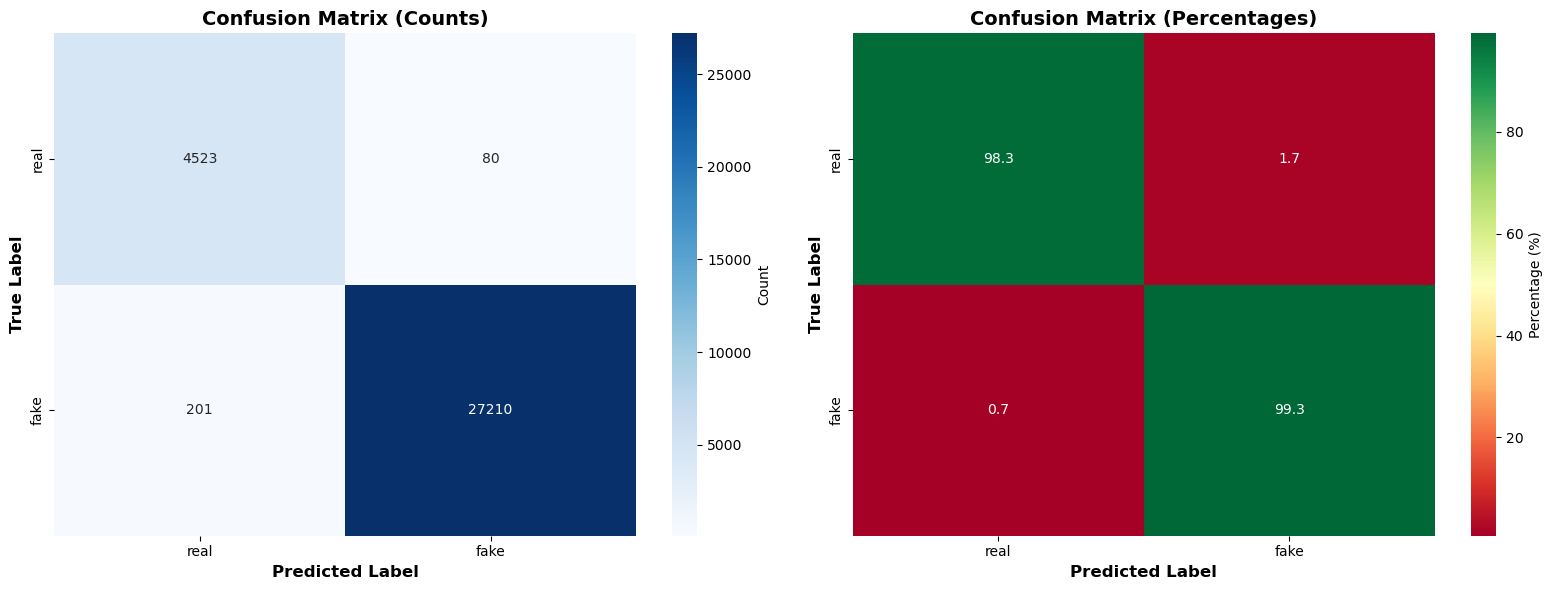


📋 Örnek tahminler:


,image_path,true_label,pred_label,prob_real,prob_fake,mask_magnitude
0,C:\AI_DATA\SEMI_TRUTHS_extracted\inpainting\Hu...,fake,fake,0.031438,0.968562,large
1,C:\AI_DATA\SEMI_TRUTHS_extracted\inpainting\AD...,fake,fake,0.018481,0.981519,medium
2,C:\AI_DATA\SEMI_TRUTHS_extracted\inpainting\Hu...,fake,fake,0.000315,0.999685,unknown
3,C:\AI_DATA\SEMI_TRUTHS_extracted\inpainting\Hu...,fake,fake,0.003053,0.996947,medium
4,C:\AI_DATA\SEMI_TRUTHS_extracted\inpainting\Ci...,fake,fake,0.000036,0.999964,medium


In [10]:
import matplotlib.pyplot as plt

# Analiz klasörü
analysis_plots_dir = os.path.join(folders["plots"], "analysis")
os.makedirs(analysis_plots_dir, exist_ok=True)

# Metrikler hesapla
metrics = calculate_metrics(
    results_df["true_label_idx"],
    results_df["pred_label_idx"],
    CLASS_NAMES
)

print("\n" + "=" * 70)
print("📊 TEST SONUÇLARI")
print("=" * 70)
print(f"Accuracy        : {metrics['accuracy']:.2%}")
print(f"Real precision  : {metrics['report']['real']['precision']:.2%}")
print(f"Fake precision  : {metrics['report']['fake']['precision']:.2%}")
print(f"Real recall     : {metrics['report']['real']['recall']:.2%}")
print(f"Fake recall     : {metrics['report']['fake']['recall']:.2%}")

# Confusion Matrix
plot_confusion_matrix(
    metrics['cm'],
    CLASS_NAMES,
    save_path=os.path.join(analysis_plots_dir, "confusion_matrix.png")
)

# Örnek tahminler
print("\n📋 Örnek tahminler:")
display(results_df.head()[[
    "image_path", "true_label", "pred_label", 
    "prob_real", "prob_fake", "mask_magnitude"
]])


## 8️⃣ Mask Magnitude Analizi


In [11]:
# Fake tahminlerde mask magnitude dağılımı
fake_preds_df = results_df[results_df["pred_label"] == "fake"].copy()

if not fake_preds_df.empty:
    magnitude_summary = (
        fake_preds_df.groupby("mask_magnitude")
        .agg(
            count=("mask_magnitude", "size"),
            avg_fake_conf=("prob_fake", "mean")
        )
        .sort_values("count", ascending=False)
    )
    magnitude_summary["ratio"] = magnitude_summary["count"] / len(fake_preds_df)
    magnitude_summary = magnitude_summary[["count", "ratio", "avg_fake_conf"]]
    magnitude_summary.columns = ["adet", "oran", "avg_fake_conf"]
    
    print("📊 Mask magnitude dağılımı (fake tahminler):")
    display(magnitude_summary.head(10))
else:
    print("Hiç fake tahmin yok.")
    magnitude_summary = pd.DataFrame()


📊 Mask magnitude dağılımı (fake tahminler):


,adet,oran,avg_fake_conf
mask_magnitude,,,
large,8637,0.316490,0.989406
small,8552,0.313375,0.989423
medium,8458,0.309930,0.989320
unknown,1643,0.060205,0.986570


## 9️⃣ Karışıklık Görselleştirmeleri


📊 Toplam karıştırılan örnek: 281


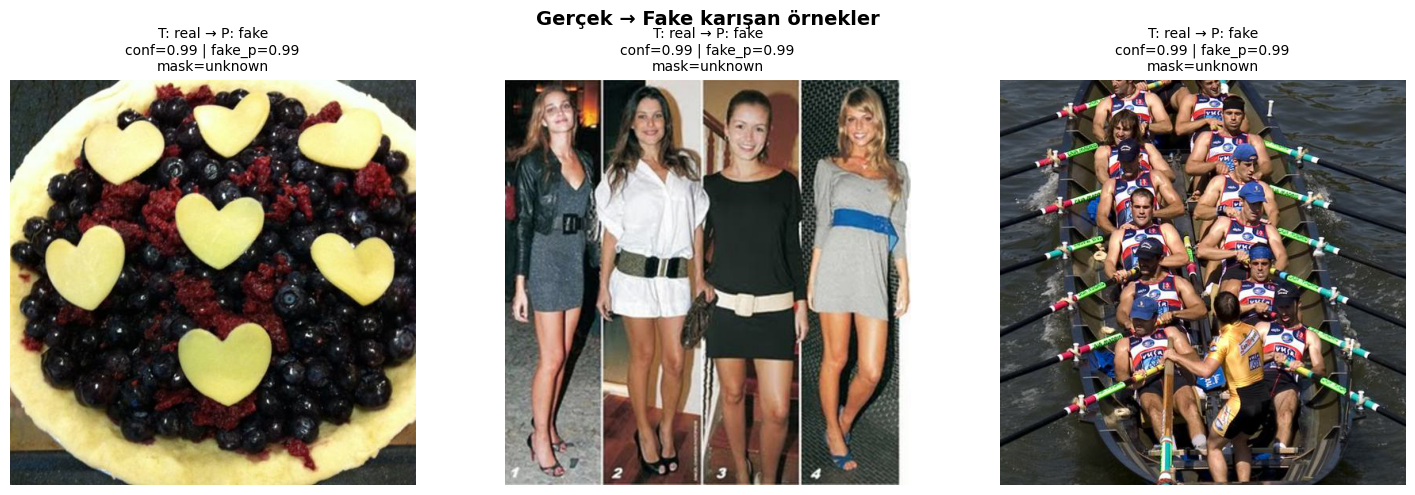

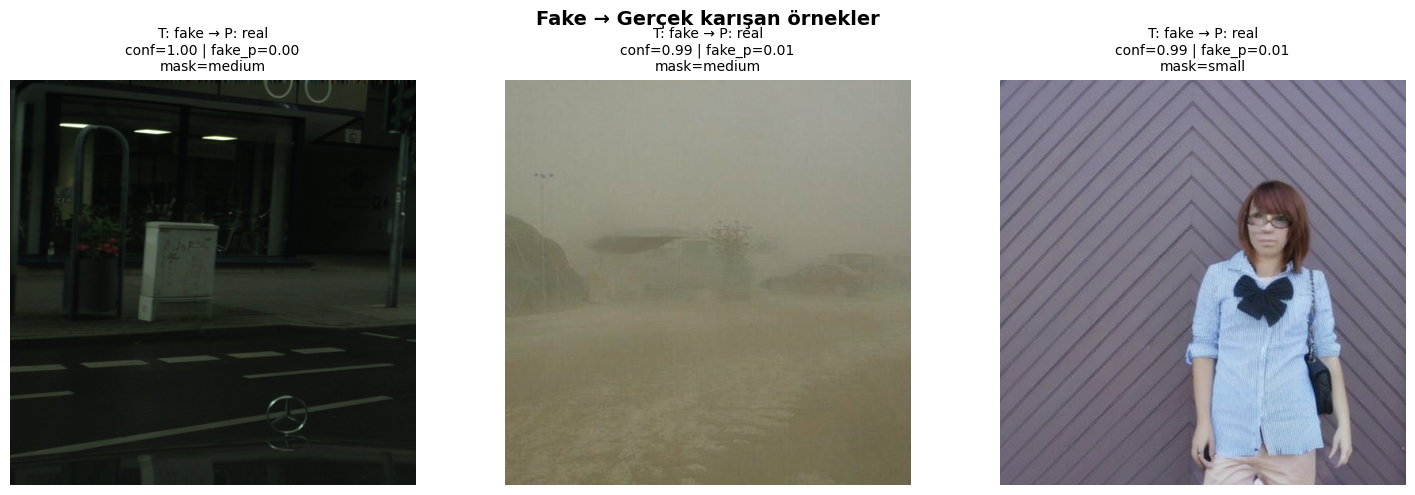

In [12]:
def show_misclassified_examples(records, title, max_examples=3):
    """Yanlış sınıflandırılmış örnekleri görselleştir."""
    if not records:
        print(f"{title}: gösterilecek örnek yok.")
        return

    cols = min(max_examples, len(records))
    plt.figure(figsize=(5 * cols, 5))

    for idx, sample in enumerate(records[:cols]):
        ax = plt.subplot(1, cols, idx + 1)
        try:
            img = Image.open(sample["image_path"]).convert("RGB")
            ax.imshow(img)
        except Exception as exc:
            ax.text(0.5, 0.5, f"Görsel yüklenemedi\n{exc}", ha="center", va="center")
        ax.axis("off")
        caption = (
            f"T: {sample['true_label']} → P: {sample['pred_label']}\n"
            f"conf={sample['confidence']:.2f} | fake_p={sample['prob_fake']:.2f}\n"
            f"mask={sample['mask_magnitude']}"
        )
        ax.set_title(caption, fontsize=10)

    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


# Karışan örnekler
misclassified_df = results_df[results_df["true_label"] != results_df["pred_label"]]
print(f"📊 Toplam karıştırılan örnek: {len(misclassified_df):,}")

real_to_fake = (
    misclassified_df[misclassified_df["true_label"] == "real"]
    .sort_values("prob_fake", ascending=False)
    .to_dict("records")
)
fake_to_real = (
    misclassified_df[misclassified_df["true_label"] == "fake"]
    .sort_values("prob_real", ascending=False)
    .to_dict("records")
)

show_misclassified_examples(real_to_fake, "Gerçek → Fake karışan örnekler", max_examples=3)
show_misclassified_examples(fake_to_real, "Fake → Gerçek karışan örnekler", max_examples=3)


## 1️⃣3️⃣ ROC Curve & AUC Analizi


✅ ROC/PR Curves kaydedildi: eğitim_sonuçları\real_fake_TEST\test_2025-12-12_23-54-29\görseller\detailed_analysis\roc_pr_curves.png


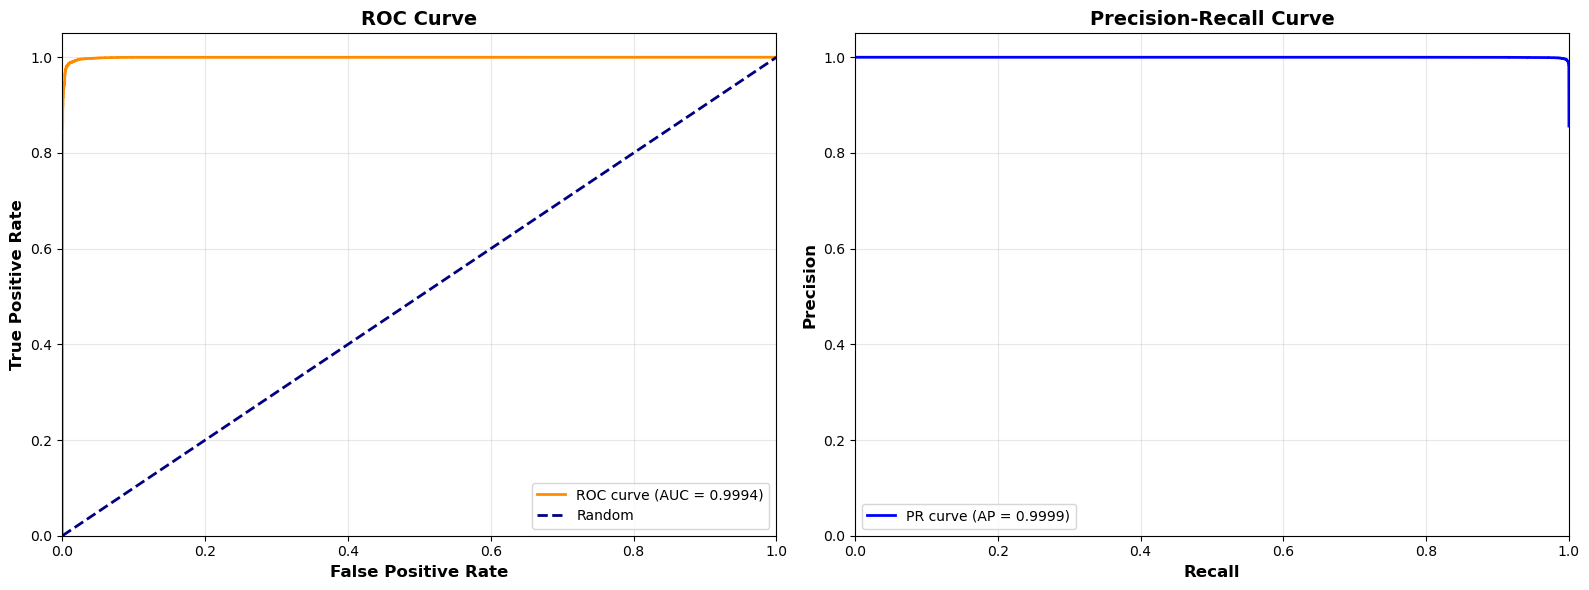


📊 ROC/AUC Metrikleri:
   AUC-ROC: 0.9994
   Average Precision: 0.9999

🎯 Optimal Threshold Analizi:
   Optimal Threshold: 0.6636
   TPR (Recall) at optimal: 0.9875
   FPR at optimal: 0.0089


ValueError: All arrays must be of the same length

In [13]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score

# ROC Curve için fake class olasılıklarını kullan
y_true_binary = (results_df["true_label_idx"] == 1).astype(int)  # 1 = fake
y_scores = results_df["prob_fake"].values

# ROC Curve
fpr, tpr, roc_thresholds = roc_curve(y_true_binary, y_scores)
roc_auc = auc(fpr, tpr)

# Precision-Recall Curve
precision, recall, pr_thresholds = precision_recall_curve(y_true_binary, y_scores)
avg_precision = average_precision_score(y_true_binary, y_scores)

# Görselleştirme
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curve
axes[0].plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.4f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
axes[0].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[0].legend(loc="lower right")
axes[0].grid(True, alpha=0.3)

# Precision-Recall Curve
axes[1].plot(recall, precision, color='blue', lw=2,
             label=f'PR curve (AP = {avg_precision:.4f})')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Recall', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Precision', fontsize=12, fontweight='bold')
axes[1].set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
axes[1].legend(loc="lower left")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
roc_path = os.path.join(folders["plots_detailed"], "roc_pr_curves.png")
fig.savefig(roc_path, dpi=150, bbox_inches="tight")
print(f"✅ ROC/PR Curves kaydedildi: {roc_path}")
plt.show()

# Özet metrikler
print(f"\n📊 ROC/AUC Metrikleri:")
print(f"   AUC-ROC: {roc_auc:.4f}")
print(f"   Average Precision: {avg_precision:.4f}")

# Optimal threshold bulma (Youden's J statistic)
youden_j = tpr - fpr
optimal_idx = np.argmax(youden_j)
optimal_threshold = roc_thresholds[optimal_idx]
optimal_fpr = fpr[optimal_idx]
optimal_tpr = tpr[optimal_idx]

print(f"\n🎯 Optimal Threshold Analizi:")
print(f"   Optimal Threshold: {optimal_threshold:.4f}")
print(f"   TPR (Recall) at optimal: {optimal_tpr:.4f}")
print(f"   FPR at optimal: {optimal_fpr:.4f}")

# Threshold analizi kaydet
threshold_analysis = pd.DataFrame({
    "threshold": roc_thresholds,
    "fpr": fpr,
    "tpr": tpr,
    "precision": precision[:-1],  # Son elemanı çıkar (1.0)
    "recall": recall[:-1]
})
threshold_analysis.to_csv(os.path.join(folders["data_analysis"], "threshold_analysis.csv"), index=False)
print(f"✅ Threshold analizi kaydedildi")


## 1️⃣4️⃣ Sınıf Bazlı Detaylı Metrikler & Hata Analizi


📊 Sınıf Bazlı Detaylı Metrikler:


,total_samples,correct_predictions,accuracy,avg_confidence,std_confidence,min_confidence,max_confidence,avg_class_prob,median_confidence,q25_confidence,q75_confidence,error_count,error_rate,avg_error_confidence,most_confused_with
real,4603,4523,0.98262,0.980593,0.066079,0.500908,1.0,0.972692,0.999914,0.997274,0.999999,80,0.01738,0.727287,{'fake': 80}
fake,27411,27210,0.992667,0.98794,0.050665,0.500065,1.0,0.984842,0.999943,0.998826,0.999999,201,0.007333,0.711216,{'real': 201}



✅ Sınıf bazlı detaylı metrikler kaydedildi
✅ Sınıf bazlı metrik görselleri kaydedildi: eğitim_sonuçları\real_fake_TEST\test_2025-12-12_23-54-29\görseller\detailed_analysis\class_detailed_metrics.png


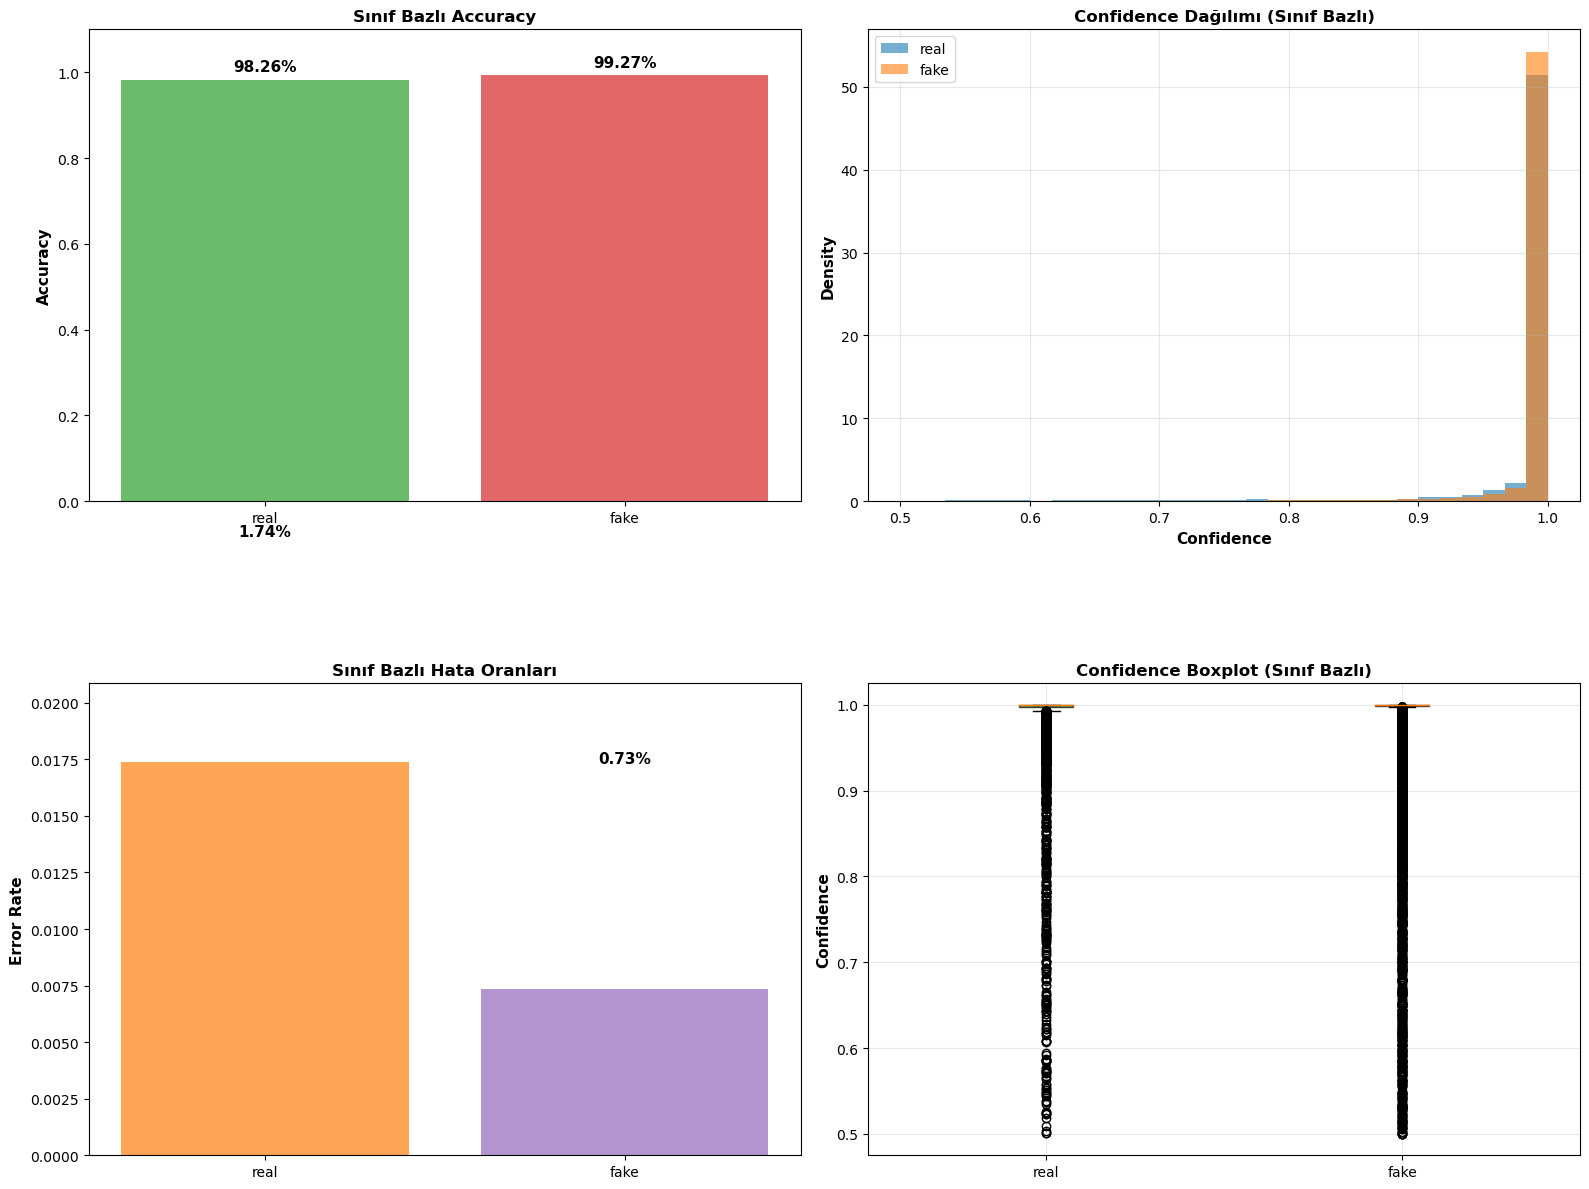

In [14]:
# Sınıf bazlı detaylı metrikler
class_detailed_metrics = {}

for class_name in CLASS_NAMES:
    class_idx = CLASS_NAMES.index(class_name)
    class_mask = results_df["true_label_idx"] == class_idx
    
    class_data = results_df[class_mask].copy()
    
    # Temel istatistikler
    class_detailed_metrics[class_name] = {
        "total_samples": len(class_data),
        "correct_predictions": (class_data["pred_label_idx"] == class_idx).sum(),
        "accuracy": (class_data["pred_label_idx"] == class_idx).mean(),
        "avg_confidence": class_data["confidence"].mean(),
        "std_confidence": class_data["confidence"].std(),
        "min_confidence": class_data["confidence"].min(),
        "max_confidence": class_data["confidence"].max(),
        "avg_class_prob": class_data[f"prob_{class_name}"].mean(),
        "median_confidence": class_data["confidence"].median(),
        "q25_confidence": class_data["confidence"].quantile(0.25),
        "q75_confidence": class_data["confidence"].quantile(0.75),
    }
    
    # Hata analizi
    errors = class_data[class_data["pred_label_idx"] != class_idx]
    if len(errors) > 0:
        class_detailed_metrics[class_name]["error_count"] = len(errors)
        class_detailed_metrics[class_name]["error_rate"] = len(errors) / len(class_data)
        class_detailed_metrics[class_name]["avg_error_confidence"] = errors["confidence"].mean()
        class_detailed_metrics[class_name]["most_confused_with"] = errors["pred_label"].value_counts().to_dict()
    else:
        class_detailed_metrics[class_name]["error_count"] = 0
        class_detailed_metrics[class_name]["error_rate"] = 0.0
        class_detailed_metrics[class_name]["avg_error_confidence"] = None
        class_detailed_metrics[class_name]["most_confused_with"] = {}

# DataFrame'e çevir
detailed_metrics_df = pd.DataFrame(class_detailed_metrics).T
detailed_metrics_df = detailed_metrics_df.round(4)

print("📊 Sınıf Bazlı Detaylı Metrikler:")
print("="*70)
display(detailed_metrics_df)

# Kaydet
detailed_metrics_df.to_csv(os.path.join(folders["data_analysis"], "class_detailed_metrics.csv"))
print(f"\n✅ Sınıf bazlı detaylı metrikler kaydedildi")

# Görselleştirme
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Sınıf bazlı accuracy
ax = axes[0, 0]
class_acc = [class_detailed_metrics[c]["accuracy"] for c in CLASS_NAMES]
bars = ax.bar(CLASS_NAMES, class_acc, color=['#2ca02c', '#d62728'], alpha=0.7)
ax.set_ylabel("Accuracy", fontsize=11, fontweight='bold')
ax.set_title("Sınıf Bazlı Accuracy", fontsize=12, fontweight='bold')
ax.set_ylim(0, 1.1)
for bar, acc in zip(bars, class_acc):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f"{acc:.2%}", ha="center", fontsize=11, fontweight='bold')

# 2. Confidence dağılımı (sınıf bazlı)
ax = axes[0, 1]
for class_name in CLASS_NAMES:
    class_idx = CLASS_NAMES.index(class_name)
    class_data = results_df[results_df["true_label_idx"] == class_idx]
    ax.hist(class_data["confidence"], bins=30, alpha=0.6, label=class_name, density=True)
ax.set_xlabel("Confidence", fontsize=11, fontweight='bold')
ax.set_ylabel("Density", fontsize=11, fontweight='bold')
ax.set_title("Confidence Dağılımı (Sınıf Bazlı)", fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Hata oranları
ax = axes[1, 0]
error_rates = [class_detailed_metrics[c]["error_rate"] for c in CLASS_NAMES]
bars = ax.bar(CLASS_NAMES, error_rates, color=['#ff7f0e', '#9467bd'], alpha=0.7)
ax.set_ylabel("Error Rate", fontsize=11, fontweight='bold')
ax.set_title("Sınıf Bazlı Hata Oranları", fontsize=12, fontweight='bold')
ax.set_ylim(0, max(error_rates) * 1.2 if max(error_rates) > 0 else 0.1)
for bar, err in zip(bars, error_rates):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f"{err:.2%}", ha="center", fontsize=11, fontweight='bold')

# 4. Confidence boxplot (sınıf bazlı)
ax = axes[1, 1]
box_data = [results_df[results_df["true_label_idx"] == i]["confidence"].values 
            for i in range(len(CLASS_NAMES))]
bp = ax.boxplot(box_data, labels=CLASS_NAMES, patch_artist=True)
for patch, color in zip(bp['boxes'], ['#2ca02c', '#d62728']):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax.set_ylabel("Confidence", fontsize=11, fontweight='bold')
ax.set_title("Confidence Boxplot (Sınıf Bazlı)", fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
class_metrics_path = os.path.join(folders["plots_detailed"], "class_detailed_metrics.png")
fig.savefig(class_metrics_path, dpi=150, bbox_inches="tight")
print(f"✅ Sınıf bazlı metrik görselleri kaydedildi: {class_metrics_path}")
plt.show()


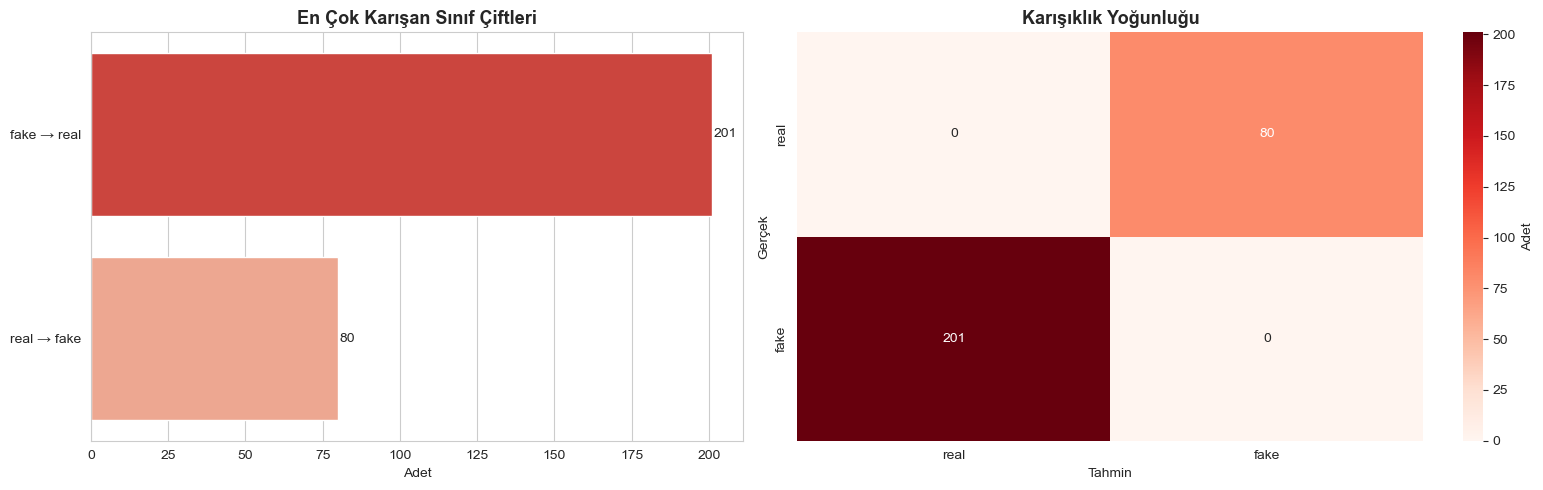

In [15]:
import seaborn as sns

sns.set_style("whitegrid")

if not misclassified_df.empty:
    misclass_counts = (
        misclassified_df.groupby(["true_label", "pred_label"])
        .size()
        .reset_index(name="count")
        .sort_values("count", ascending=False)
    )
    misclass_counts["pair"] = misclass_counts.apply(
        lambda row: f"{row['true_label']} → {row['pred_label']}", axis=1
    )
    top_pairs = misclass_counts.head(10)

    fig, axes = plt.subplots(1, 2, figsize=(16, 5), gridspec_kw={"width_ratios": [1, 1.2]})

    sns.barplot(
        data=top_pairs,
        x="count",
        y="pair",
        palette="Reds_r",
        ax=axes[0]
    )
    axes[0].set_title("En Çok Karışan Sınıf Çiftleri", fontsize=13, fontweight='bold')
    axes[0].set_xlabel("Adet")
    axes[0].set_ylabel("")
    for i, val in enumerate(top_pairs["count"]):
        axes[0].text(val + 0.5, i, f"{val}", va="center")

    misclass_pivot = (
        misclassified_df.groupby(["true_label", "pred_label"]).size()
        .unstack(fill_value=0)
        .reindex(index=CLASS_NAMES, columns=CLASS_NAMES, fill_value=0)
    )
    sns.heatmap(
        misclass_pivot,
        annot=True,
        fmt="d",
        cmap="Reds",
        cbar_kws={"label": "Adet"},
        ax=axes[1]
    )
    axes[1].set_title("Karışıklık Yoğunluğu", fontsize=13, fontweight='bold')
    axes[1].set_xlabel("Tahmin")
    axes[1].set_ylabel("Gerçek")

    plt.tight_layout()
    fig.savefig(os.path.join(analysis_plots_dir, "misclassification_summary.png"), dpi=150, bbox_inches="tight")
    plt.show()
else:
    print("Karışıklık bulunamadı - model çok iyi!")


## 🔟 Confidence Dağılımları


c:\Users\emrec\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
c:\Users\emrec\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


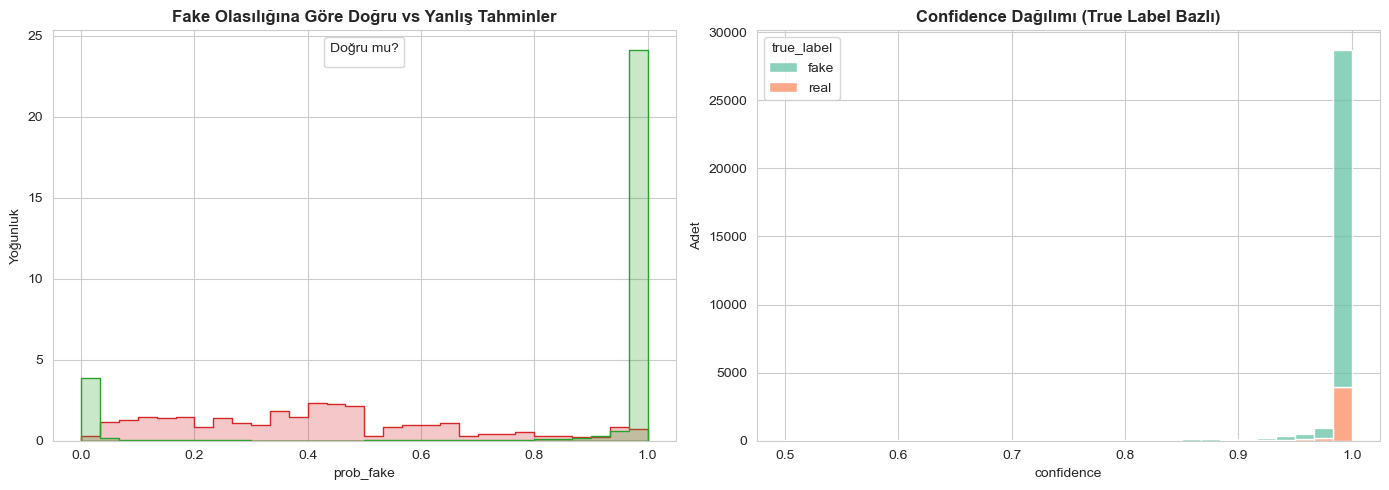

In [16]:
results_df = results_df.copy()
results_df["is_correct"] = results_df["true_label_idx"] == results_df["pred_label_idx"]
results_df["correct_label"] = results_df["is_correct"].map({True: "Doğru", False: "Yanlış"})

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(
    data=results_df,
    x="prob_fake",
    hue="correct_label",
    bins=30,
    palette={"Doğru": "#2ca02c", "Yanlış": "#d62728"},
    ax=axes[0],
    element="step",
    stat="density",
    common_norm=False
)
axes[0].set_title("Fake Olasılığına Göre Doğru vs Yanlış Tahminler", fontsize=12, fontweight='bold')
axes[0].set_xlabel("prob_fake")
axes[0].set_ylabel("Yoğunluk")
axes[0].legend(title="Doğru mu?", loc="upper center")

sns.histplot(
    data=results_df,
    x="confidence",
    hue="true_label",
    bins=30,
    palette="Set2",
    multiple="stack",
    ax=axes[1]
)
axes[1].set_title("Confidence Dağılımı (True Label Bazlı)", fontsize=12, fontweight='bold')
axes[1].set_xlabel("confidence")
axes[1].set_ylabel("Adet")

plt.tight_layout()
fig.savefig(os.path.join(analysis_plots_dir, "confidence_distributions.png"), dpi=150, bbox_inches="tight")
plt.show()


## 1️⃣1️⃣ Mask Magnitude x Hata Analizi


📊 Yanlış tahminlerin mask magnitude dağılımı:


,adet,oran_%
mask_magnitude,,
small,69,34.33
medium,70,34.83
large,62,30.85


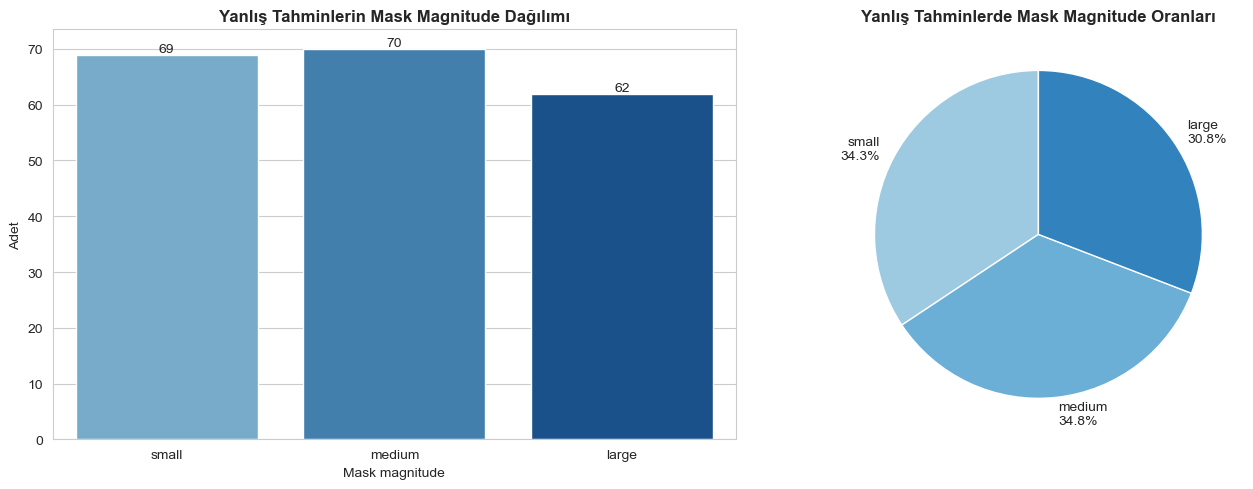

In [17]:
mask_focus = ["small", "medium", "large"]
misclassified_with_mag = (
    results_df[(results_df["true_label"] != results_df["pred_label"]) &
               (results_df["mask_magnitude"].isin(mask_focus))]
    .copy()
)

if misclassified_with_mag.empty:
    print("Small/medium/large etiketli karışıklık bulunamadı.")
else:
    mag_error_counts = (
        misclassified_with_mag.groupby("mask_magnitude").size()
        .reindex(mask_focus, fill_value=0)
    )
    mag_error_ratios = (mag_error_counts / mag_error_counts.sum()) * 100
    
    print("📊 Yanlış tahminlerin mask magnitude dağılımı:")
    display(pd.DataFrame({
        "adet": mag_error_counts,
        "oran_%": mag_error_ratios.round(2)
    }))

    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    sns.barplot(
        x=mag_error_counts.index,
        y=mag_error_counts.values,
        palette=["#6baed6", "#3182bd", "#08519c"],
        ax=ax[0]
    )
    ax[0].set_title("Yanlış Tahminlerin Mask Magnitude Dağılımı", fontsize=12, fontweight='bold')
    ax[0].set_xlabel("Mask magnitude")
    ax[0].set_ylabel("Adet")
    for idx, val in enumerate(mag_error_counts.values):
        ax[0].text(idx, val + 0.5, f"{val}", ha="center")

    ax[1].pie(
        mag_error_counts.values,
        labels=[f"{lbl}\n{ratio:.1f}%" for lbl, ratio in zip(mag_error_counts.index, mag_error_ratios)],
        colors=["#9ecae1", "#6baed6", "#3182bd"],
        autopct="", startangle=90
    )
    ax[1].set_title("Yanlış Tahminlerde Mask Magnitude Oranları", fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    fig.savefig(os.path.join(analysis_plots_dir, "misclassified_mask_magnitude.png"), dpi=150, bbox_inches="tight")
    plt.show()


## 1️⃣2️⃣ Sayısal Sem-Magnitude Analizi (area_ratio, ssim, mse, lpips, dreamsim)


In [18]:
# Sayısal metriklerin analizi (sadece fake resimler için geçerli)
fake_df = results_df[results_df["true_label"] == "fake"].copy()
numeric_metrics = ["area_ratio", "ssim", "mse", "lpips_score", "dreamsim"]

print("=" * 70)
print("📊 SAYISAL SEM-MAGNITUDE ANALİZİ")
print("=" * 70)

# Her metrik için özet istatistikler
metric_stats = {}
for metric in numeric_metrics:
    valid_data = fake_df[fake_df[metric].notna()][metric]
    if len(valid_data) > 0:
        metric_stats[metric] = {
            "count": len(valid_data),
            "mean": valid_data.mean(),
            "std": valid_data.std(),
            "min": valid_data.min(),
            "max": valid_data.max(),
            "median": valid_data.median()
        }

if metric_stats:
    stats_df = pd.DataFrame(metric_stats).T
    stats_df = stats_df.round(4)
    print("\n📋 Sayısal Metrik İstatistikleri (Fake Resimler):")
    display(stats_df)
else:
    print("⚠️ Hiç sayısal metrik bulunamadı!")


📊 SAYISAL SEM-MAGNITUDE ANALİZİ

📋 Sayısal Metrik İstatistikleri (Fake Resimler):


,count,mean,std,min,max,median
area_ratio,25848.0,0.1095,0.1723,0.0050,1.0000,0.0311
ssim,25848.0,0.8125,0.1411,0.0922,0.9875,0.8550
mse,25848.0,0.0145,0.0277,0.0001,0.3486,0.0050
lpips_score,25848.0,0.1056,0.1146,0.0087,0.8865,0.0634
dreamsim,25848.0,0.1420,0.1662,0.0047,0.9243,0.0636


In [19]:
# ============================================
# 📋 TEST SONUÇLARINI METADATA'YA EKLE
# ============================================
# Test sonuçlarını metadata'ya ekle
test_results_metadata = {
    "total_samples": len(results_df),
    "accuracy": float(metrics['accuracy']),
    "class_metrics": {
        class_name: {
            "precision": float(metrics['report'][class_name]['precision']),
            "recall": float(metrics['report'][class_name]['recall']),
            "f1_score": float(metrics['report'][class_name]['f1-score']),
            "support": int(metrics['report'][class_name]['support'])
        }
        for class_name in CLASS_NAMES
    },
    "confusion_matrix": metrics['cm'].tolist(),
    "data_statistics": {
        "real_samples": int((results_df["true_label"] == "real").sum()),
        "fake_samples": int((results_df["true_label"] == "fake").sum()),
        "correct_predictions": int(results_df["is_correct"].sum()),
        "incorrect_predictions": int((~results_df["is_correct"]).sum()),
        "avg_confidence": float(results_df["confidence"].mean()),
        "std_confidence": float(results_df["confidence"].std())
    }
}

# ROC/AUC varsa ekle
if 'roc_auc' in globals():
    test_results_metadata["roc_auc"] = float(roc_auc)
    test_results_metadata["avg_precision"] = float(avg_precision)
    if 'optimal_threshold' in globals():
        test_results_metadata["optimal_threshold"] = float(optimal_threshold)

# Veri istatistiklerini ekle
test_results_metadata["dataset_statistics"] = {
    "total_dataset_size": len(full_dataset),
    "train_samples": len(train_full_indices),
    "val_samples": len(val_full_indices),
    "real_samples_original": label_counts[0],
    "fake_samples_original": label_counts[1],
    "balanced_real_samples": len(real_subset),
    "balanced_fake_samples": len(fake_subset)
}

# Metadata'yı güncelle
test_metadata["test_results"] = test_results_metadata
metadata_path = os.path.join(folders["root"], "test_metadata.json")
with open(metadata_path, "w", encoding="utf-8") as f:
    json.dump(test_metadata, f, indent=2, ensure_ascii=False)

print(f"\n✅ Test metadata güncellendi: {metadata_path}")
print(f"\n📊 Test Özeti:")
print(f"   Toplam Örnek: {len(results_df):,}")
print(f"   Accuracy: {metrics['accuracy']:.2%}")
if 'roc_auc' in globals():
    print(f"   ROC-AUC: {roc_auc:.4f}")
    print(f"   Avg Precision: {avg_precision:.4f}")



✅ Test metadata güncellendi: eğitim_sonuçları\real_fake_TEST\test_2025-12-12_23-54-29\test_metadata.json

📊 Test Özeti:
   Toplam Örnek: 32,014
   Accuracy: 99.12%
   ROC-AUC: 0.9994
   Avg Precision: 0.9999


C:\Users\emrec\AppData\Local\Temp\ipykernel_8828\2892034397.py:40: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
C:\Users\emrec\AppData\Local\Temp\ipykernel_8828\2892034397.py:41: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.savefig(os.path.join(analysis_plots_dir, "numeric_metrics_distribution.png"), dpi=150, bbox_inches="tight")
c:\Users\emrec\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


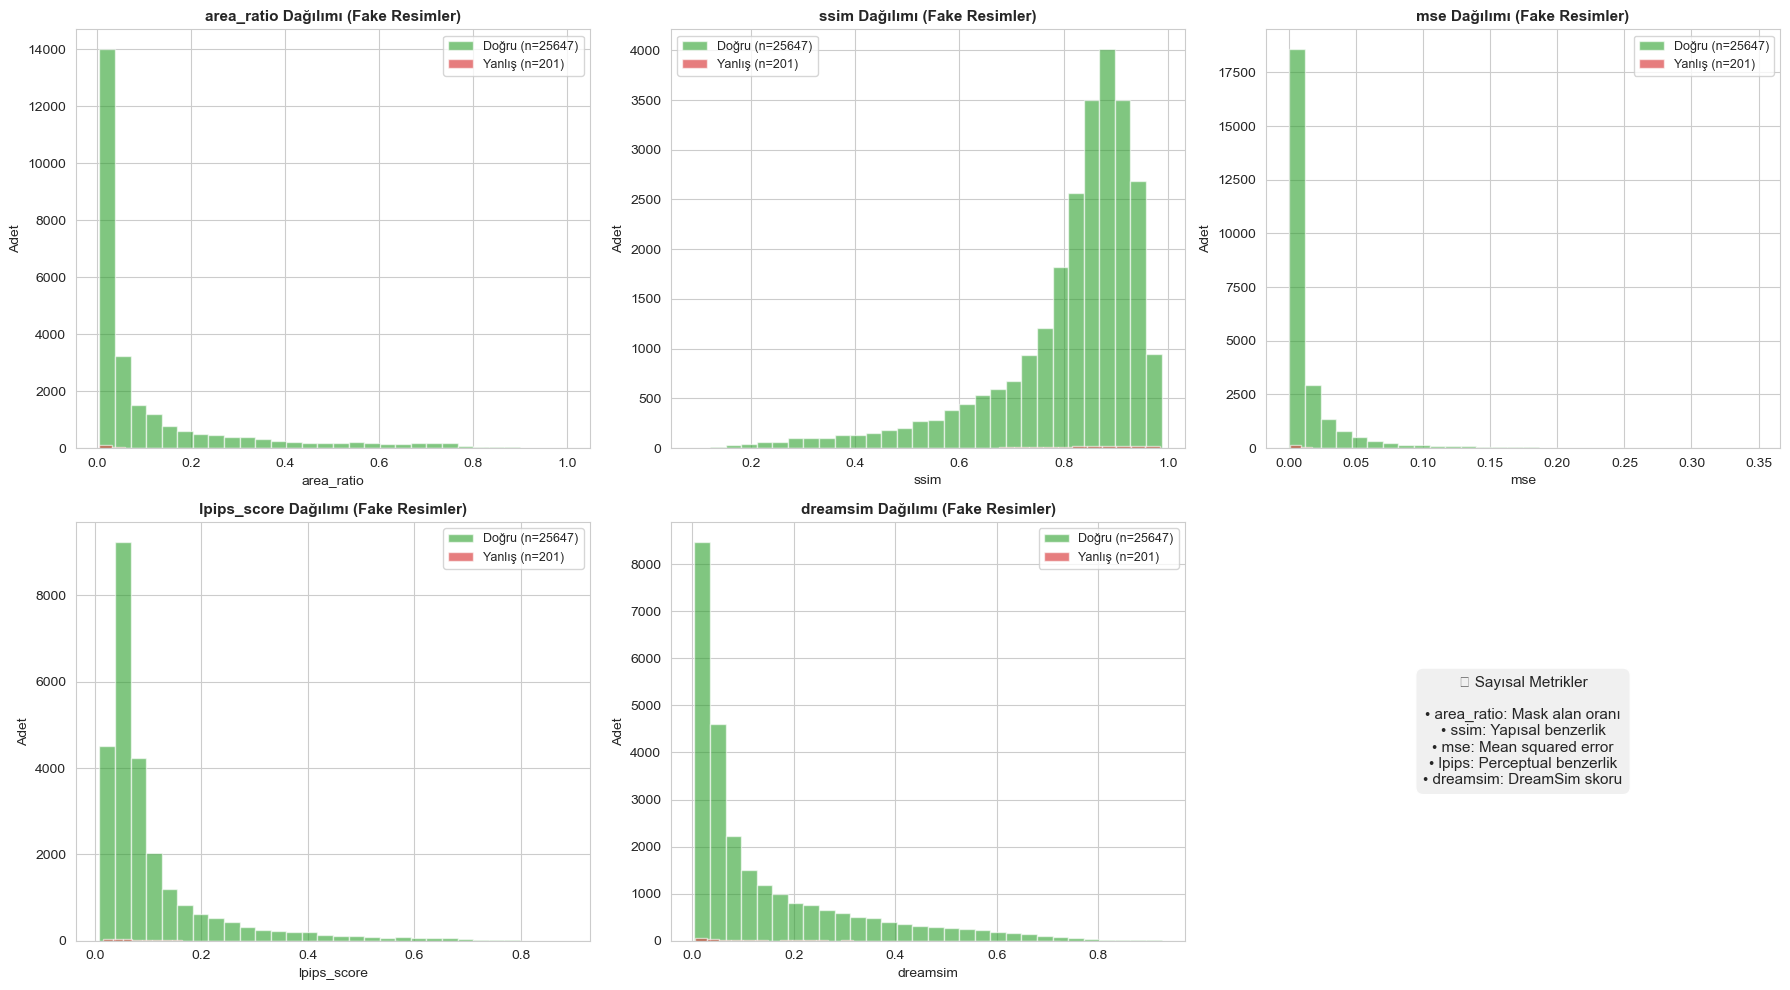

In [ ]:
# Sayısal metriklerin dağılım görselleştirmeleri
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, metric in enumerate(numeric_metrics):
    ax = axes[idx]
    valid_data = fake_df[fake_df[metric].notna()]
    
    if len(valid_data) == 0:
        ax.text(0.5, 0.5, f"{metric}\nVeri yok", ha="center", va="center", fontsize=12)
        ax.set_title(metric, fontsize=12, fontweight='bold')
        continue
    
    # Doğru vs Yanlış tahmin ayrımı
    correct_data = valid_data[valid_data["is_correct"]][metric]
    wrong_data = valid_data[~valid_data["is_correct"]][metric]
    
    # Histogram
    if len(correct_data) > 0:
        ax.hist(correct_data, bins=30, alpha=0.6, label=f"Doğru (n={len(correct_data)})", color="#2ca02c")
    if len(wrong_data) > 0:
        ax.hist(wrong_data, bins=30, alpha=0.6, label=f"Yanlış (n={len(wrong_data)})", color="#d62728")
    
    ax.set_xlabel(metric, fontsize=10)
    ax.set_ylabel("Adet", fontsize=10)
    ax.set_title(f"{metric} Dağılımı (Fake Resimler)", fontsize=11, fontweight='bold')
    ax.legend(fontsize=9)

# Son hücreyi boş bırak veya özet bilgi koy
axes[-1].axis("off")
axes[-1].text(0.5, 0.5, "📊 Sayısal Metrikler\n\n" + 
              "• area_ratio: Mask alan oranı\n" +
              "• ssim: Yapısal benzerlik\n" +
              "• mse: Mean squared error\n" +
              "• lpips: Perceptual benzerlik\n" +
              "• dreamsim: DreamSim skoru",
              ha="center", va="center", fontsize=11, 
              bbox=dict(boxstyle="round,pad=0.5", facecolor="#f0f0f0"))

plt.tight_layout()
fig.savefig(os.path.join(analysis_plots_dir, "numeric_metrics_distribution.png"), dpi=150, bbox_inches="tight")
plt.show()


C:\Users\emrec\AppData\Local\Temp\ipykernel_8828\3253233352.py:52: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
C:\Users\emrec\AppData\Local\Temp\ipykernel_8828\3253233352.py:53: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.savefig(os.path.join(analysis_plots_dir, "magnitude_vs_metrics_boxplot.png"), dpi=150, bbox_inches="tight")
c:\Users\emrec\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


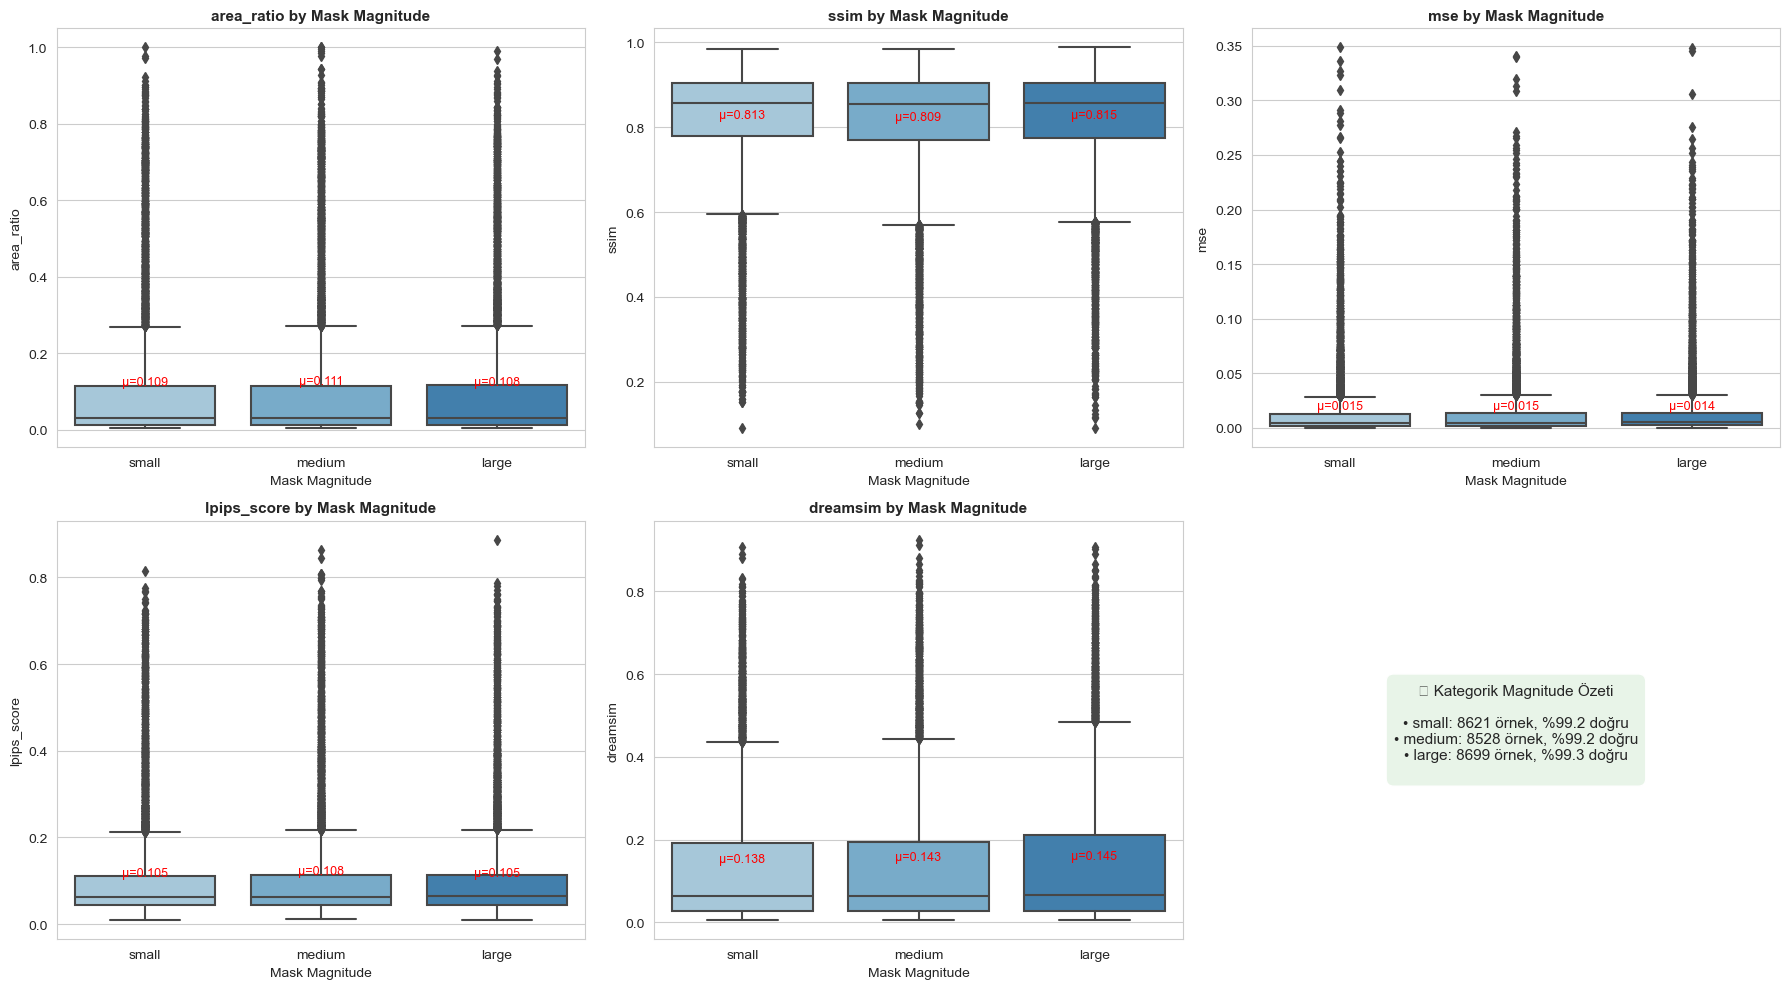

In [21]:
# Kategorik magnitude (small/medium/large) vs Sayısal metrikler karşılaştırması
mask_focus = ["small", "medium", "large"]
fake_with_mag = fake_df[fake_df["mask_magnitude"].isin(mask_focus)].copy()

if fake_with_mag.empty:
    print("⚠️ Small/medium/large kategorili fake örnek bulunamadı.")
else:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    for idx, metric in enumerate(numeric_metrics):
        ax = axes[idx]
        valid_data = fake_with_mag[fake_with_mag[metric].notna()]
        
        if len(valid_data) == 0:
            ax.text(0.5, 0.5, f"{metric}\nVeri yok", ha="center", va="center", fontsize=12)
            ax.set_title(metric, fontsize=12, fontweight='bold')
            continue
        
        # Boxplot
        sns.boxplot(
            data=valid_data,
            x="mask_magnitude",
            y=metric,
            order=mask_focus,
            palette=["#9ecae1", "#6baed6", "#3182bd"],
            ax=ax
        )
        
        # Her kategori için ortalama değerleri göster
        means = valid_data.groupby("mask_magnitude")[metric].mean()
        for i, mag in enumerate(mask_focus):
            if mag in means.index:
                ax.text(i, means[mag], f"μ={means[mag]:.3f}", ha="center", va="bottom", fontsize=9, color="red")
        
        ax.set_xlabel("Mask Magnitude", fontsize=10)
        ax.set_ylabel(metric, fontsize=10)
        ax.set_title(f"{metric} by Mask Magnitude", fontsize=11, fontweight='bold')
    
    # Özet istatistik tablosu
    axes[-1].axis("off")
    summary_text = "📊 Kategorik Magnitude Özeti\n\n"
    for mag in mask_focus:
        count = len(fake_with_mag[fake_with_mag["mask_magnitude"] == mag])
        correct = fake_with_mag[(fake_with_mag["mask_magnitude"] == mag) & (fake_with_mag["is_correct"])].shape[0]
        acc = (correct / count * 100) if count > 0 else 0
        summary_text += f"• {mag}: {count} örnek, %{acc:.1f} doğru\n"
    
    axes[-1].text(0.5, 0.5, summary_text, ha="center", va="center", fontsize=11,
                  bbox=dict(boxstyle="round,pad=0.5", facecolor="#e8f4e8"))
    
    plt.tight_layout()
    fig.savefig(os.path.join(analysis_plots_dir, "magnitude_vs_metrics_boxplot.png"), dpi=150, bbox_inches="tight")
    plt.show()


📊 SAYISAL METRİKLER vs MODEL PERFORMANSI

📋 Korelasyon Tablosu:
   - corr_dogruluk: Metrik ile doğru tahmin arasındaki korelasyon
   - corr_prob_fake: Metrik ile fake olasılığı arasındaki korelasyon


,corr_dogruluk,corr_prob_fake,n
area_ratio,-0.0052,-0.0153,25848.0
ssim,0.0058,0.0273,25848.0
mse,-0.0054,-0.0261,25848.0
lpips_score,-0.0013,-0.0200,25848.0
dreamsim,-0.0015,0.0015,25848.0


C:\Users\emrec\AppData\Local\Temp\ipykernel_8828\75965644.py:68: UserWarning: Glyph 128214 (\N{OPEN BOOK}) missing from current font.
  plt.tight_layout()
C:\Users\emrec\AppData\Local\Temp\ipykernel_8828\75965644.py:69: UserWarning: Glyph 128214 (\N{OPEN BOOK}) missing from current font.
  fig.savefig(os.path.join(analysis_plots_dir, "metrics_correlation.png"), dpi=150, bbox_inches="tight")
c:\Users\emrec\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128214 (\N{OPEN BOOK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


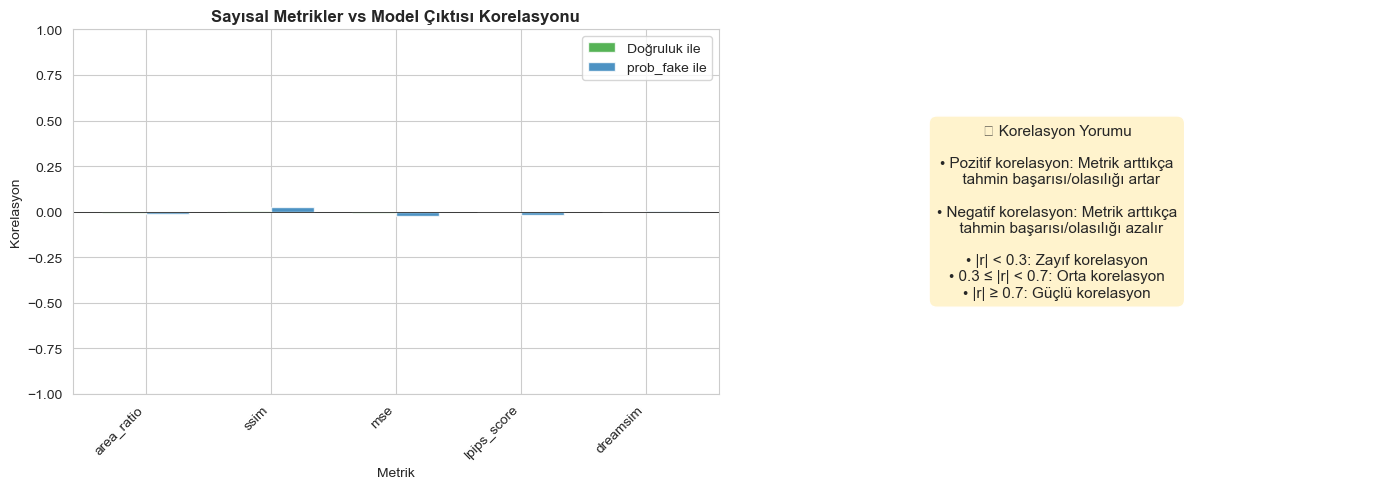

In [22]:
# Sayısal Metrikler vs Model Performansı Korelasyon Analizi
print("=" * 70)
print("📊 SAYISAL METRİKLER vs MODEL PERFORMANSI")
print("=" * 70)

# Fake örneklerde sayısal metrikler ile doğruluk arasındaki korelasyon
if not fake_df.empty:
    # is_correct'u sayısal yap (1=doğru, 0=yanlış)
    fake_df["is_correct_num"] = fake_df["is_correct"].astype(int)
    
    corr_results = {}
    for metric in numeric_metrics:
        valid = fake_df[[metric, "is_correct_num", "prob_fake"]].dropna()
        if len(valid) > 10:
            corr_with_correct = valid[metric].corr(valid["is_correct_num"])
            corr_with_prob = valid[metric].corr(valid["prob_fake"])
            corr_results[metric] = {
                "corr_dogruluk": corr_with_correct,
                "corr_prob_fake": corr_with_prob,
                "n": len(valid)
            }
    
    if corr_results:
        corr_df = pd.DataFrame(corr_results).T.round(4)
        print("\n📋 Korelasyon Tablosu:")
        print("   - corr_dogruluk: Metrik ile doğru tahmin arasındaki korelasyon")
        print("   - corr_prob_fake: Metrik ile fake olasılığı arasındaki korelasyon")
        display(corr_df)
        
        # Korelasyon heatmap
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Bar chart - korelasyonlar
        ax = axes[0]
        x = np.arange(len(corr_results))
        width = 0.35
        metrics_list = list(corr_results.keys())
        corr_dogruluk = [corr_results[m]["corr_dogruluk"] for m in metrics_list]
        corr_prob = [corr_results[m]["corr_prob_fake"] for m in metrics_list]
        
        bars1 = ax.bar(x - width/2, corr_dogruluk, width, label="Doğruluk ile", color="#2ca02c", alpha=0.8)
        bars2 = ax.bar(x + width/2, corr_prob, width, label="prob_fake ile", color="#1f77b4", alpha=0.8)
        
        ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
        ax.set_xlabel("Metrik")
        ax.set_ylabel("Korelasyon")
        ax.set_title("Sayısal Metrikler vs Model Çıktısı Korelasyonu", fontsize=12, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(metrics_list, rotation=45, ha="right")
        ax.legend()
        ax.set_ylim(-1, 1)
        
        # Açıklama
        axes[1].axis("off")
        explain_text = (
            "📖 Korelasyon Yorumu\n\n"
            "• Pozitif korelasyon: Metrik arttıkça\n"
            "  tahmin başarısı/olasılığı artar\n\n"
            "• Negatif korelasyon: Metrik arttıkça\n"
            "  tahmin başarısı/olasılığı azalır\n\n"
            "• |r| < 0.3: Zayıf korelasyon\n"
            "• 0.3 ≤ |r| < 0.7: Orta korelasyon\n"
            "• |r| ≥ 0.7: Güçlü korelasyon"
        )
        axes[1].text(0.5, 0.5, explain_text, ha="center", va="center", fontsize=11,
                     bbox=dict(boxstyle="round,pad=0.5", facecolor="#fff3cd"))
        
        plt.tight_layout()
        fig.savefig(os.path.join(analysis_plots_dir, "metrics_correlation.png"), dpi=150, bbox_inches="tight")
        plt.show()
    else:
        print("⚠️ Korelasyon hesaplamak için yeterli veri yok.")
else:
    print("⚠️ Fake örnek bulunamadı.")


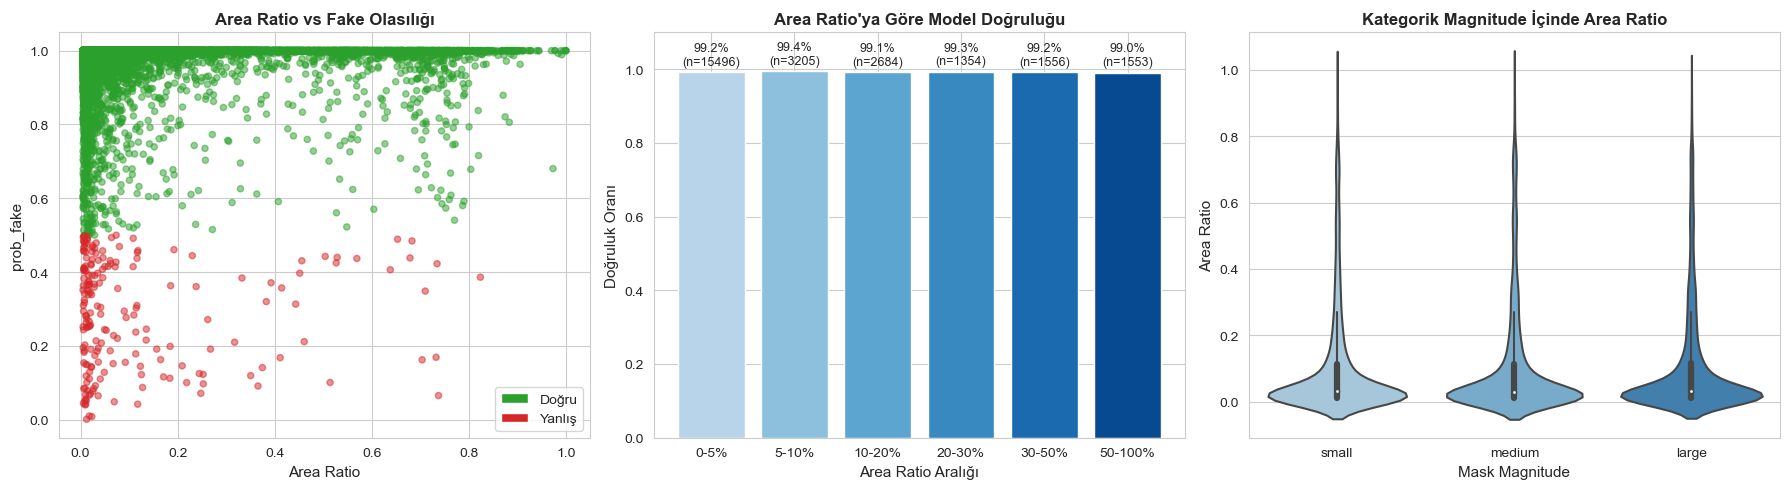


📊 Area Ratio Aralıklarına Göre Doğruluk:


,area_bin,correct,total,accuracy
0,0-5%,15375,15496,0.992192
1,5-10%,3186,3205,0.994072
2,10-20%,2661,2684,0.991431
3,20-30%,1344,1354,0.992614
4,30-50%,1543,1556,0.991645
5,50-100%,1538,1553,0.990341


In [23]:
# Area Ratio Detaylı Analizi - Scatter Plot ve Binned Accuracy
valid_area = fake_df[fake_df["area_ratio"].notna()].copy()

if len(valid_area) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # 1. Scatter plot: area_ratio vs prob_fake
    ax = axes[0]
    colors = valid_area["is_correct"].map({True: "#2ca02c", False: "#d62728"})
    ax.scatter(valid_area["area_ratio"], valid_area["prob_fake"], 
               c=colors, alpha=0.5, s=20)
    ax.set_xlabel("Area Ratio", fontsize=11)
    ax.set_ylabel("prob_fake", fontsize=11)
    ax.set_title("Area Ratio vs Fake Olasılığı", fontsize=12, fontweight='bold')
    
    # Legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='#2ca02c', label='Doğru'),
                       Patch(facecolor='#d62728', label='Yanlış')]
    ax.legend(handles=legend_elements)
    
    # 2. Binned Accuracy - area_ratio aralıklarına göre doğruluk
    ax = axes[1]
    valid_area["area_bin"] = pd.cut(valid_area["area_ratio"], 
                                     bins=[0, 0.05, 0.1, 0.2, 0.3, 0.5, 1.0],
                                     labels=["0-5%", "5-10%", "10-20%", "20-30%", "30-50%", "50-100%"])
    
    bin_accuracy = valid_area.groupby("area_bin", observed=True).agg({
        "is_correct": ["sum", "count", "mean"]
    })
    bin_accuracy.columns = ["correct", "total", "accuracy"]
    bin_accuracy = bin_accuracy.reset_index()
    
    bars = ax.bar(bin_accuracy["area_bin"].astype(str), bin_accuracy["accuracy"], 
                  color=plt.cm.Blues(np.linspace(0.3, 0.9, len(bin_accuracy))))
    ax.set_xlabel("Area Ratio Aralığı", fontsize=11)
    ax.set_ylabel("Doğruluk Oranı", fontsize=11)
    ax.set_title("Area Ratio'ya Göre Model Doğruluğu", fontsize=12, fontweight='bold')
    ax.set_ylim(0, 1.1)
    
    # Bar üstüne değer yaz
    for bar, row in zip(bars, bin_accuracy.itertuples()):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                f"{row.accuracy:.1%}\n(n={int(row.total)})", ha="center", fontsize=9)
    
    # 3. Kategorik magnitude içinde area_ratio dağılımı (violin plot)
    ax = axes[2]
    mask_focus = ["small", "medium", "large"]
    valid_with_mag = valid_area[valid_area["mask_magnitude"].isin(mask_focus)]
    
    if len(valid_with_mag) > 0:
        sns.violinplot(data=valid_with_mag, x="mask_magnitude", y="area_ratio",
                       order=mask_focus, palette=["#9ecae1", "#6baed6", "#3182bd"], ax=ax)
        ax.set_xlabel("Mask Magnitude", fontsize=11)
        ax.set_ylabel("Area Ratio", fontsize=11)
        ax.set_title("Kategorik Magnitude İçinde Area Ratio", fontsize=12, fontweight='bold')
    else:
        ax.text(0.5, 0.5, "Veri yok", ha="center", va="center")
    
    plt.tight_layout()
    fig.savefig(os.path.join(analysis_plots_dir, "area_ratio_detailed.png"), dpi=150, bbox_inches="tight")
    plt.show()
    
    # Özet tablo
    print("\n📊 Area Ratio Aralıklarına Göre Doğruluk:")
    display(bin_accuracy)
else:
    print("⚠️ Area ratio verisi bulunamadı.")


## 💾 Verileri Kaydet


In [24]:
# Veri kaydetme klasörü
data_dir = os.path.join(folders["data"], "analysis")
os.makedirs(data_dir, exist_ok=True)

print("💾 VERİLER KAYDEDİLİYOR...")
print("="*70)

# 1. Tüm tahminler
results_df.to_csv(os.path.join(data_dir, "all_predictions.csv"), index=False)
print(f"✅ all_predictions.csv ({len(results_df):,} satır)")

# 2. Özet metrikler
summary_data = {
    "metric": ["accuracy", "real_precision", "real_recall", "real_f1", 
               "fake_precision", "fake_recall", "fake_f1", "total_samples"],
    "value": [
        metrics['accuracy'],
        metrics['report']['real']['precision'],
        metrics['report']['real']['recall'],
        metrics['report']['real']['f1-score'],
        metrics['report']['fake']['precision'],
        metrics['report']['fake']['recall'],
        metrics['report']['fake']['f1-score'],
        len(results_df)
    ]
}
pd.DataFrame(summary_data).to_csv(os.path.join(data_dir, "summary_metrics.csv"), index=False)
print("✅ summary_metrics.csv")

# 3. Confusion matrix
cm_df = pd.DataFrame(
    metrics['cm'],
    index=[f"true_{c}" for c in CLASS_NAMES],
    columns=[f"pred_{c}" for c in CLASS_NAMES]
)
cm_df.to_csv(os.path.join(data_dir, "confusion_matrix.csv"))
print("✅ confusion_matrix.csv")

# 4. Semantic magnitude dağılımı (fake tahminler)
if 'semantic_summary' in globals() and not semantic_summary.empty:
    semantic_summary.to_csv(os.path.join(data_dir, "semantic_magnitude_fake_predictions.csv"))
    print("✅ semantic_magnitude_fake_predictions.csv")

# 5. Mask magnitude dağılımı (fake tahminler)
if 'mask_summary' in globals() and not mask_summary.empty:
    mask_summary.to_csv(os.path.join(data_dir, "mask_magnitude_fake_predictions.csv"))
    print("✅ mask_magnitude_fake_predictions.csv")

# 6. Yanlış sınıflandırmalar
if not misclassified_df.empty:
    misclassified_df.to_csv(os.path.join(data_dir, "misclassified_samples.csv"), index=False)
    print(f"✅ misclassified_samples.csv ({len(misclassified_df):,} satır)")

# 7. Sınıf bazlı confidence istatistikleri
confidence_stats = results_df.groupby("true_label").agg({
    "confidence": ["mean", "std", "min", "max"],
    "prob_real": ["mean", "std"],
    "prob_fake": ["mean", "std"]
}).round(4)
confidence_stats.columns = ['_'.join(col).strip() for col in confidence_stats.columns.values]
confidence_stats.to_csv(os.path.join(data_dir, "confidence_statistics.csv"))
print("✅ confidence_statistics.csv")

# 8. Semantic magnitude x doğruluk analizi
if "semantic_magnitude" in results_df.columns:
    sem_mag_accuracy = results_df.groupby("semantic_magnitude").agg({
        "is_correct": ["sum", "count", "mean"]
    }).round(4)
    sem_mag_accuracy.columns = ["correct", "total", "accuracy"]
    sem_mag_accuracy = sem_mag_accuracy.sort_values("total", ascending=False)
    sem_mag_accuracy.to_csv(os.path.join(data_dir, "semantic_magnitude_accuracy.csv"))
    print("✅ semantic_magnitude_accuracy.csv")

# 9. Mask magnitude x doğruluk analizi
if "mask_magnitude" in results_df.columns:
    mask_mag_accuracy = results_df.groupby("mask_magnitude").agg({
        "is_correct": ["sum", "count", "mean"]
    }).round(4)
    mask_mag_accuracy.columns = ["correct", "total", "accuracy"]
    mask_mag_accuracy = mask_mag_accuracy.sort_values("total", ascending=False)
    mask_mag_accuracy.to_csv(os.path.join(data_dir, "mask_magnitude_accuracy.csv"))
    print("✅ mask_magnitude_accuracy.csv")

print(f"\n📁 Tüm veriler kaydedildi: {data_dir}")


💾 VERİLER KAYDEDİLİYOR...
✅ all_predictions.csv (32,014 satır)
✅ summary_metrics.csv
✅ confusion_matrix.csv
✅ mask_magnitude_fake_predictions.csv
✅ misclassified_samples.csv (281 satır)
✅ confidence_statistics.csv
✅ mask_magnitude_accuracy.csv

📁 Tüm veriler kaydedildi: eğitim_sonuçları\real_fake_TEST\test_2025-12-12_23-54-29\veriler\analysis


## ✅ Sonuç

Test tamamlandı! Tüm görseller `eğitim_sonuçları/real_fake_TEST/görseller/analysis/` klasörüne kaydedildi.
